In [93]:
import os
import numpy as np
import pandas as pd
import cv2
from ultralytics import YOLO
from tqdm import tqdm  # nice progress bars
import time
import matplotlib.pyplot as plt
import random
from glob import glob

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# RAW MODELS TRAINING

from glob import glob
import gc
import seaborn as sns

# Pytorch
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import csv


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


YOLO Transfer Train

In [ ]:
detector = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)
# detector.train(
#     data='dataset/data.yaml', 
#     epochs=100, 
#     imgsz=640, 
#     batch=16, 
#     name='yolo_transfer_model', 
#     device=0, 
#     patience=50, 
# ) OLD ONE
detector.train(data='dataset/data.yaml', 
               epochs=100, 
               imgsz=640, 
               batch=16, 
               name='yolo_transfer_model', 
               device=0, 
               patience=50, 
               pretrained=False,
               hsv_h=0.015,
               hsv_s=0.7,
               hsv_v=0.4,
               degrees=90, 
               translate=0.2,
               scale=0.5,
               shear=20,
               perspective=0.0,
               flipud=1,
               fliplr=1,
               bgr=0.0,
               mosaic=1.0,
               mixup=0.0,
               cutmix=0.0,
               copy_paste=0.0,
               copy_paste_mode = 'flip',
               auto_augment = 'randaugment',
               erasing=0.4,
               ) # Train the mode

detector = YOLO("runs/detect/yolo_transfer_model/weights/best.pt")
metrics = detector.val()
print(metrics)


In [ ]:
# Clean Up GPU

# 1. Run Python garbage collector
gc.collect()

# 2. Clear PyTorch cached memory
torch.cuda.empty_cache()

# 3. Reset PyTorch CUDA memory allocator
torch.cuda.synchronize()

In [ ]:
detector = YOLO("runs/detect/yolo_transfer_model2/weights/best.pt")
metrics = detector.val()
print(metrics)


YOLO Raw Train

In [ ]:
detector = YOLO("yolo11n.yaml") # Create a new model from YAML

detector.train(data='dataset/data.yaml', 
               epochs=100, 
               imgsz=640, 
               batch=16, 
               name='yolo_raw_model', 
               device=0, 
               patience=50, 
               pretrained=False,
               hsv_h=0.015,
               hsv_s=0.7,
               hsv_v=0.4,
               degrees=90, 
               translate=0.2,
               scale=0.5,
               shear=20,
               perspective=0.0,
               flipud=1,
               fliplr=1,
               bgr=0.0,
               mosaic=1.0,
               mixup=0.0,
               cutmix=0.0,
               copy_paste=0.0,
               copy_paste_mode = 'flip',
               auto_augment = 'randaugment',
               erasing=0.4,
               ) # Train the mode

detector = YOLO("runs/detect/yolo_raw_model/weights/best.pt")
metrics = detector.val()
print(metrics)

In [3]:
# Clean Up GPU

# 1. Run Python garbage collector
gc.collect()

# 2. Clear PyTorch cached memory
torch.cuda.empty_cache()

# 3. Reset PyTorch CUDA memory allocator
torch.cuda.synchronize()


In [79]:
# Function To Evaluate Model
def evaluate(model, dataloader, class_names, device, name):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    print(f"\n===================== {name} Classification Performance =====================")

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)

            probs = F.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)

    # METRICS
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted")
    rec = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # ROC-AUC
    num_classes = len(class_names)
    y_true_oh = np.zeros((len(y_true), num_classes))
    for i, label in enumerate(y_true):
        y_true_oh[i][label] = 1

    auc = roc_auc_score(y_true_oh, y_prob, average="weighted", multi_class="ovr")
    print(f"AUC      : {auc:.4f}")

    print("\n===== Classification Report =====\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix (Normalized)
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} Confusion Matrix (Normalized)")
    plt.tight_layout()
    plt.savefig(f"{name}_confusion_matrix_normalized.png")
    print(f"Normalized confusion matrix saved as {name}_confusion_matrix_normalized.png")

    # Per-class accuracy
    cm_raw = confusion_matrix(y_true, y_pred)
    per_class_accuracy = cm_raw.diagonal() / cm_raw.sum(axis=1)

    print("\nPer-class accuracy:")
    for cls, acc in zip(class_names, per_class_accuracy):
        print(f"{cls}: {acc:.4f}")

    print("===============================================================================\n")

def setupResnet50Raw(dataset_path, name):
    res_data_root = dataset_path    
    batch_size = 32               # Higher batch is okay for ResNet50
    num_workers = 8              # Use 0 if RAM is small; 2 is safe
    num_epochs = 70               # Enough for transfer learning
    learning_rate = 1e-4
    img_size = 224                # ResNet50 requires 224x224 input

    temp_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(f"{dataset_path}/train", transform=temp_transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images

    print("MEAN:", mean)
    print("STD:", std)


    # Data transformations (augmentation + normalization)
    train_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        
        # --- YOLO-style color jitter ---
        transforms.ColorJitter(
            hue=0.015,        # hsv_h
            saturation=0.7,   # hsv_s
            brightness=0.4    # hsv_v
        ),
        
        # --- Spatial augmentations ---
        transforms.RandomRotation(90),          # degrees=90
        transforms.RandomAffine(
            degrees=0,
            translate=(0.2, 0.2),                # translate=0.2
            scale=(0.5, 1.5),                    # scale=0.5 (min)
            shear=20                             # shear=20
        ),
        transforms.RandomHorizontalFlip(p=1.0),  # fliplr=1
        transforms.RandomVerticalFlip(p=1.0),    # flipud=1
        
        # --- YOLO autoaugment equivalent ---
        transforms.RandAugment(),                # auto_augment = "randaugment"
        
        # --- Random erasing applied after tensor ---
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.4),         # erasing=0.4
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])

    val_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())
    ])

    # Load datasets

    train_ds = datasets.ImageFolder(os.path.join(res_data_root, "train"), transform=train_tf)
    val_ds   = datasets.ImageFolder(os.path.join(res_data_root, "valid"), transform=val_tf)
    test_ds  = datasets.ImageFolder(os.path.join(res_data_root, "test"),  transform=val_tf)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, dataset, None, name, num_epochs, learning_rate

def setupResnet50Transfer(dataset_path, name):
    res_data_root = dataset_path  
    batch_size = 32               # Higher batch is okay for ResNet50
    num_workers = 2               # Use 0 if RAM is small; 2 is safe
    num_epochs = 70               # Enough for transfer learning
    learning_rate = 1e-4
    img_size = 224                # ResNet50 requires 224x224 input

    # Load pretrained weights
    weights = ResNet50_Weights.IMAGENET1K_V2

    # ImageNet normalisation stats from pretrained weights
    imagenet_mean = weights.transforms().mean
    imagenet_std = weights.transforms().std

    # training transfomrations
    train_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        
        # --- YOLO-style color jitter ---
        transforms.ColorJitter(
            hue=0.015,        # hsv_h
            saturation=0.7,   # hsv_s
            brightness=0.4    # hsv_v
        ),
        
        # --- Spatial augmentations ---
        transforms.RandomRotation(90),          # degrees=90
        transforms.RandomAffine(
            degrees=0,
            translate=(0.2, 0.2),                # translate=0.2
            scale=(0.5, 1.5),                    # scale=0.5 (min)
            shear=20                             # shear=20
        ),
        transforms.RandomHorizontalFlip(p=1.0),  # fliplr=1
        transforms.RandomVerticalFlip(p=1.0),    # flipud=1
        
        # --- YOLO autoaugment equivalent ---
        transforms.RandAugment(),                # auto_augment = "randaugment"
        
        # --- Random erasing applied after tensor ---
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.4),         # erasing=0.4
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    # validation + test transformation
    test_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    # Create PyTorch datasets and dataloaders using folder structure
    train_ds = datasets.ImageFolder(os.path.join(res_data_root, "train"), transform=train_tf)
    val_ds   = datasets.ImageFolder(os.path.join(res_data_root, "valid"), transform=test_tf)
    test_ds  = datasets.ImageFolder(os.path.join(res_data_root, "test"),  transform=test_tf)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, train_ds, weights, name, 70, learning_rate, test_tf
    
    
def trainResNet50Model(train_loader, val_loader, test_loader, dataset, weights, name, num_epochs=70, learning_rate=0.001, transfer=True):
    logfile = f"resnet_{name}.csv"

    # Create and write header
    with open(logfile, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "val_acc"])

    resnet_model = models.resnet50(weights=weights)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = resnet_model.to(device)
    if (transfer):
        # freeze feature extractor
        for param in resnet_model.parameters():
            param.requires_grad = False
            
        # replace final layer with dataset classes
        resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 12)
        resnet_model = resnet_model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimiser = optim.Adam(resnet_model.fc.parameters(), lr=learning_rate)
    else:
        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimiser = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        resnet_model.train()
        train_loss = 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimiser.zero_grad()
            outputs = resnet_model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()

            train_loss += loss.item()

        # Validation
        resnet_model.eval()
        val_loss = 0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = resnet_model(imgs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss:   {val_loss/len(val_loader):.4f}")
        print(f"Val Acc:    {100*val_correct/total:.2f}%\n")

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss   = val_loss / len(val_loader)
        val_acc        = 100 * val_correct / total

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss:   {avg_val_loss:.4f}")
        print(f"Val Acc:    {val_acc:.2f}%\n")

    with open(logfile, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss, val_acc])


    torch.save(model.state_dict(), f"resnet50_{name}_custom.pth")
    evaluate(model, test_loader, dataset.classes, device, name)

        # Stop GPU Exploding
    del model
    del optimiser
    del train_loader
    del val_loader
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    return

ResNet Raw Train

In [ ]:
trainResNet50Model(*setupResnet50Raw("cropped_dataset", "raw"))

ResNet Transfer Train

Epoch 1/70: 100%|██████████| 478/478 [00:54<00:00,  8.84it/s]


Epoch 1/70
Train Loss: 1.4826
Val Loss:   1.3512
Val Acc:    62.86%

Epoch 1/70
Train Loss: 1.4826
Val Loss:   1.3512
Val Acc:    62.86%



Epoch 2/70: 100%|██████████| 478/478 [00:53<00:00,  8.85it/s]


Epoch 2/70
Train Loss: 1.0217
Val Loss:   1.5132
Val Acc:    64.50%

Epoch 2/70
Train Loss: 1.0217
Val Loss:   1.5132
Val Acc:    64.50%



Epoch 3/70: 100%|██████████| 478/478 [00:54<00:00,  8.84it/s]


Epoch 3/70
Train Loss: 0.8866
Val Loss:   1.0596
Val Acc:    72.56%

Epoch 3/70
Train Loss: 0.8866
Val Loss:   1.0596
Val Acc:    72.56%



Epoch 4/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 4/70
Train Loss: 0.8239
Val Loss:   0.8723
Val Acc:    72.26%

Epoch 4/70
Train Loss: 0.8239
Val Loss:   0.8723
Val Acc:    72.26%



Epoch 5/70: 100%|██████████| 478/478 [00:54<00:00,  8.85it/s]


Epoch 5/70
Train Loss: 0.7651
Val Loss:   0.7690
Val Acc:    77.33%

Epoch 5/70
Train Loss: 0.7651
Val Loss:   0.7690
Val Acc:    77.33%



Epoch 6/70: 100%|██████████| 478/478 [00:53<00:00,  8.85it/s]


Epoch 6/70
Train Loss: 0.7277
Val Loss:   0.8886
Val Acc:    73.45%

Epoch 6/70
Train Loss: 0.7277
Val Loss:   0.8886
Val Acc:    73.45%



Epoch 7/70: 100%|██████████| 478/478 [00:54<00:00,  8.83it/s]


Epoch 7/70
Train Loss: 0.6880
Val Loss:   0.8583
Val Acc:    77.85%

Epoch 7/70
Train Loss: 0.6880
Val Loss:   0.8583
Val Acc:    77.85%



Epoch 8/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 8/70
Train Loss: 0.6503
Val Loss:   0.8462
Val Acc:    75.02%

Epoch 8/70
Train Loss: 0.6503
Val Loss:   0.8462
Val Acc:    75.02%



Epoch 9/70: 100%|██████████| 478/478 [00:54<00:00,  8.82it/s]


Epoch 9/70
Train Loss: 0.6140
Val Loss:   0.8649
Val Acc:    77.93%

Epoch 9/70
Train Loss: 0.6140
Val Loss:   0.8649
Val Acc:    77.93%



Epoch 10/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 10/70
Train Loss: 0.5892
Val Loss:   0.9292
Val Acc:    76.21%

Epoch 10/70
Train Loss: 0.5892
Val Loss:   0.9292
Val Acc:    76.21%



Epoch 11/70: 100%|██████████| 478/478 [00:54<00:00,  8.84it/s]


Epoch 11/70
Train Loss: 0.5628
Val Loss:   0.7851
Val Acc:    79.19%

Epoch 11/70
Train Loss: 0.5628
Val Loss:   0.7851
Val Acc:    79.19%



Epoch 12/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 12/70
Train Loss: 0.5492
Val Loss:   0.6954
Val Acc:    80.69%

Epoch 12/70
Train Loss: 0.5492
Val Loss:   0.6954
Val Acc:    80.69%



Epoch 13/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 13/70
Train Loss: 0.5381
Val Loss:   0.7837
Val Acc:    81.51%

Epoch 13/70
Train Loss: 0.5381
Val Loss:   0.7837
Val Acc:    81.51%



Epoch 14/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 14/70
Train Loss: 0.5072
Val Loss:   0.8084
Val Acc:    81.06%

Epoch 14/70
Train Loss: 0.5072
Val Loss:   0.8084
Val Acc:    81.06%



Epoch 15/70: 100%|██████████| 478/478 [00:53<00:00,  8.85it/s]


Epoch 15/70
Train Loss: 0.5065
Val Loss:   0.6873
Val Acc:    82.40%

Epoch 15/70
Train Loss: 0.5065
Val Loss:   0.6873
Val Acc:    82.40%



Epoch 16/70: 100%|██████████| 478/478 [00:53<00:00,  8.85it/s]


Epoch 16/70
Train Loss: 0.4899
Val Loss:   0.6946
Val Acc:    81.88%

Epoch 16/70
Train Loss: 0.4899
Val Loss:   0.6946
Val Acc:    81.88%



Epoch 17/70: 100%|██████████| 478/478 [00:54<00:00,  8.85it/s]


Epoch 17/70
Train Loss: 0.4672
Val Loss:   0.7665
Val Acc:    80.69%

Epoch 17/70
Train Loss: 0.4672
Val Loss:   0.7665
Val Acc:    80.69%



Epoch 18/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 18/70
Train Loss: 0.4438
Val Loss:   0.8617
Val Acc:    79.64%

Epoch 18/70
Train Loss: 0.4438
Val Loss:   0.8617
Val Acc:    79.64%



Epoch 19/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 19/70
Train Loss: 0.4404
Val Loss:   0.7498
Val Acc:    80.84%

Epoch 19/70
Train Loss: 0.4404
Val Loss:   0.7498
Val Acc:    80.84%



Epoch 20/70: 100%|██████████| 478/478 [00:54<00:00,  8.84it/s]


Epoch 20/70
Train Loss: 0.4193
Val Loss:   0.9172
Val Acc:    78.60%

Epoch 20/70
Train Loss: 0.4193
Val Loss:   0.9172
Val Acc:    78.60%



Epoch 21/70: 100%|██████████| 478/478 [00:54<00:00,  8.85it/s]


Epoch 21/70
Train Loss: 0.4048
Val Loss:   0.7067
Val Acc:    82.77%

Epoch 21/70
Train Loss: 0.4048
Val Loss:   0.7067
Val Acc:    82.77%



Epoch 22/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 22/70
Train Loss: 0.4008
Val Loss:   0.6707
Val Acc:    83.59%

Epoch 22/70
Train Loss: 0.4008
Val Loss:   0.6707
Val Acc:    83.59%



Epoch 23/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 23/70
Train Loss: 0.3863
Val Loss:   0.7825
Val Acc:    81.28%

Epoch 23/70
Train Loss: 0.3863
Val Loss:   0.7825
Val Acc:    81.28%



Epoch 24/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 24/70
Train Loss: 0.3695
Val Loss:   0.6539
Val Acc:    83.45%

Epoch 24/70
Train Loss: 0.3695
Val Loss:   0.6539
Val Acc:    83.45%



Epoch 25/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 25/70
Train Loss: 0.3687
Val Loss:   0.6465
Val Acc:    83.22%

Epoch 25/70
Train Loss: 0.3687
Val Loss:   0.6465
Val Acc:    83.22%



Epoch 26/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 26/70
Train Loss: 0.3686
Val Loss:   0.6732
Val Acc:    83.30%

Epoch 26/70
Train Loss: 0.3686
Val Loss:   0.6732
Val Acc:    83.30%



Epoch 27/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 27/70
Train Loss: 0.3460
Val Loss:   0.7703
Val Acc:    83.15%

Epoch 27/70
Train Loss: 0.3460
Val Loss:   0.7703
Val Acc:    83.15%



Epoch 28/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 28/70
Train Loss: 0.3337
Val Loss:   0.7715
Val Acc:    83.30%

Epoch 28/70
Train Loss: 0.3337
Val Loss:   0.7715
Val Acc:    83.30%



Epoch 29/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 29/70
Train Loss: 0.3347
Val Loss:   0.7670
Val Acc:    83.45%

Epoch 29/70
Train Loss: 0.3347
Val Loss:   0.7670
Val Acc:    83.45%



Epoch 30/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 30/70
Train Loss: 0.3385
Val Loss:   0.6685
Val Acc:    83.30%

Epoch 30/70
Train Loss: 0.3385
Val Loss:   0.6685
Val Acc:    83.30%



Epoch 31/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 31/70
Train Loss: 0.3144
Val Loss:   0.6694
Val Acc:    83.07%

Epoch 31/70
Train Loss: 0.3144
Val Loss:   0.6694
Val Acc:    83.07%



Epoch 32/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 32/70
Train Loss: 0.3055
Val Loss:   0.7457
Val Acc:    83.22%

Epoch 32/70
Train Loss: 0.3055
Val Loss:   0.7457
Val Acc:    83.22%



Epoch 33/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 33/70
Train Loss: 0.3168
Val Loss:   0.8137
Val Acc:    82.25%

Epoch 33/70
Train Loss: 0.3168
Val Loss:   0.8137
Val Acc:    82.25%



Epoch 34/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 34/70
Train Loss: 0.3020
Val Loss:   0.7635
Val Acc:    83.15%

Epoch 34/70
Train Loss: 0.3020
Val Loss:   0.7635
Val Acc:    83.15%



Epoch 35/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 35/70
Train Loss: 0.2934
Val Loss:   0.7877
Val Acc:    83.37%

Epoch 35/70
Train Loss: 0.2934
Val Loss:   0.7877
Val Acc:    83.37%



Epoch 36/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 36/70
Train Loss: 0.2790
Val Loss:   0.7232
Val Acc:    83.37%

Epoch 36/70
Train Loss: 0.2790
Val Loss:   0.7232
Val Acc:    83.37%



Epoch 37/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 37/70
Train Loss: 0.2929
Val Loss:   0.7082
Val Acc:    83.22%

Epoch 37/70
Train Loss: 0.2929
Val Loss:   0.7082
Val Acc:    83.22%



Epoch 38/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 38/70
Train Loss: 0.2792
Val Loss:   0.8023
Val Acc:    83.30%

Epoch 38/70
Train Loss: 0.2792
Val Loss:   0.8023
Val Acc:    83.30%



Epoch 39/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 39/70
Train Loss: 0.2744
Val Loss:   0.7773
Val Acc:    84.64%

Epoch 39/70
Train Loss: 0.2744
Val Loss:   0.7773
Val Acc:    84.64%



Epoch 40/70: 100%|██████████| 478/478 [00:54<00:00,  8.85it/s]


Epoch 40/70
Train Loss: 0.2654
Val Loss:   0.8129
Val Acc:    82.62%

Epoch 40/70
Train Loss: 0.2654
Val Loss:   0.8129
Val Acc:    82.62%



Epoch 41/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 41/70
Train Loss: 0.2737
Val Loss:   0.8206
Val Acc:    82.70%

Epoch 41/70
Train Loss: 0.2737
Val Loss:   0.8206
Val Acc:    82.70%



Epoch 42/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 42/70
Train Loss: 0.2615
Val Loss:   0.7734
Val Acc:    82.48%

Epoch 42/70
Train Loss: 0.2615
Val Loss:   0.7734
Val Acc:    82.48%



Epoch 43/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 43/70
Train Loss: 0.2483
Val Loss:   0.7345
Val Acc:    84.56%

Epoch 43/70
Train Loss: 0.2483
Val Loss:   0.7345
Val Acc:    84.56%



Epoch 44/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 44/70
Train Loss: 0.2452
Val Loss:   0.8464
Val Acc:    84.71%

Epoch 44/70
Train Loss: 0.2452
Val Loss:   0.8464
Val Acc:    84.71%



Epoch 45/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 45/70
Train Loss: 0.2507
Val Loss:   0.7857
Val Acc:    84.56%

Epoch 45/70
Train Loss: 0.2507
Val Loss:   0.7857
Val Acc:    84.56%



Epoch 46/70: 100%|██████████| 478/478 [00:53<00:00,  8.87it/s]


Epoch 46/70
Train Loss: 0.2388
Val Loss:   0.7552
Val Acc:    84.71%

Epoch 46/70
Train Loss: 0.2388
Val Loss:   0.7552
Val Acc:    84.71%



Epoch 47/70: 100%|██████████| 478/478 [00:53<00:00,  8.86it/s]


Epoch 47/70
Train Loss: 0.2418
Val Loss:   0.8903
Val Acc:    82.62%

Epoch 47/70
Train Loss: 0.2418
Val Loss:   0.8903
Val Acc:    82.62%



Epoch 48/70: 100%|██████████| 478/478 [00:54<00:00,  8.81it/s]


Epoch 48/70
Train Loss: 0.2352
Val Loss:   0.6721
Val Acc:    85.98%

Epoch 48/70
Train Loss: 0.2352
Val Loss:   0.6721
Val Acc:    85.98%



Epoch 49/70: 100%|██████████| 478/478 [00:54<00:00,  8.82it/s]


Epoch 49/70
Train Loss: 0.2405
Val Loss:   0.8138
Val Acc:    85.09%

Epoch 49/70
Train Loss: 0.2405
Val Loss:   0.8138
Val Acc:    85.09%



Epoch 50/70: 100%|██████████| 478/478 [00:54<00:00,  8.82it/s]


Epoch 50/70
Train Loss: 0.2365
Val Loss:   0.8180
Val Acc:    83.07%

Epoch 50/70
Train Loss: 0.2365
Val Loss:   0.8180
Val Acc:    83.07%



Epoch 51/70: 100%|██████████| 478/478 [00:54<00:00,  8.82it/s]


Epoch 51/70
Train Loss: 0.2228
Val Loss:   0.8000
Val Acc:    84.41%

Epoch 51/70
Train Loss: 0.2228
Val Loss:   0.8000
Val Acc:    84.41%



Epoch 52/70: 100%|██████████| 478/478 [00:54<00:00,  8.83it/s]


Epoch 52/70
Train Loss: 0.2171
Val Loss:   0.7984
Val Acc:    83.97%

Epoch 52/70
Train Loss: 0.2171
Val Loss:   0.7984
Val Acc:    83.97%



Epoch 53/70: 100%|██████████| 478/478 [00:54<00:00,  8.83it/s]


Epoch 53/70
Train Loss: 0.2238
Val Loss:   0.7100
Val Acc:    85.53%

Epoch 53/70
Train Loss: 0.2238
Val Loss:   0.7100
Val Acc:    85.53%



Epoch 54/70: 100%|██████████| 478/478 [00:54<00:00,  8.81it/s]


Epoch 54/70
Train Loss: 0.2185
Val Loss:   0.8282
Val Acc:    84.49%

Epoch 54/70
Train Loss: 0.2185
Val Loss:   0.8282
Val Acc:    84.49%



Epoch 55/70: 100%|██████████| 478/478 [00:54<00:00,  8.80it/s]


Epoch 55/70
Train Loss: 0.2129
Val Loss:   0.8429
Val Acc:    83.30%

Epoch 55/70
Train Loss: 0.2129
Val Loss:   0.8429
Val Acc:    83.30%



Epoch 56/70: 100%|██████████| 478/478 [00:54<00:00,  8.81it/s]


Epoch 56/70
Train Loss: 0.2119
Val Loss:   1.0016
Val Acc:    81.88%

Epoch 56/70
Train Loss: 0.2119
Val Loss:   1.0016
Val Acc:    81.88%



Epoch 57/70: 100%|██████████| 478/478 [00:54<00:00,  8.82it/s]


Epoch 57/70
Train Loss: 0.2106
Val Loss:   0.8252
Val Acc:    83.89%

Epoch 57/70
Train Loss: 0.2106
Val Loss:   0.8252
Val Acc:    83.89%



Epoch 58/70: 100%|██████████| 478/478 [00:54<00:00,  8.80it/s]


Epoch 58/70
Train Loss: 0.2143
Val Loss:   0.8369
Val Acc:    85.09%

Epoch 58/70
Train Loss: 0.2143
Val Loss:   0.8369
Val Acc:    85.09%



Epoch 59/70: 100%|██████████| 478/478 [00:54<00:00,  8.82it/s]


Epoch 59/70
Train Loss: 0.2020
Val Loss:   0.9676
Val Acc:    84.34%

Epoch 59/70
Train Loss: 0.2020
Val Loss:   0.9676
Val Acc:    84.34%



Epoch 60/70: 100%|██████████| 478/478 [00:54<00:00,  8.83it/s]


Epoch 60/70
Train Loss: 0.2024
Val Loss:   0.8606
Val Acc:    83.22%

Epoch 60/70
Train Loss: 0.2024
Val Loss:   0.8606
Val Acc:    83.22%



Epoch 61/70: 100%|██████████| 478/478 [00:54<00:00,  8.81it/s]


Epoch 61/70
Train Loss: 0.1999
Val Loss:   0.8906
Val Acc:    84.64%

Epoch 61/70
Train Loss: 0.1999
Val Loss:   0.8906
Val Acc:    84.64%



Epoch 62/70: 100%|██████████| 478/478 [00:54<00:00,  8.81it/s]


Epoch 62/70
Train Loss: 0.1976
Val Loss:   0.9792
Val Acc:    81.95%

Epoch 62/70
Train Loss: 0.1976
Val Loss:   0.9792
Val Acc:    81.95%



Epoch 63/70: 100%|██████████| 478/478 [00:56<00:00,  8.43it/s]


Epoch 63/70
Train Loss: 0.1924
Val Loss:   0.7538
Val Acc:    85.09%

Epoch 63/70
Train Loss: 0.1924
Val Loss:   0.7538
Val Acc:    85.09%



Epoch 64/70: 100%|██████████| 478/478 [00:54<00:00,  8.81it/s]


Epoch 64/70
Train Loss: 0.1928
Val Loss:   0.8657
Val Acc:    84.12%

Epoch 64/70
Train Loss: 0.1928
Val Loss:   0.8657
Val Acc:    84.12%



Epoch 65/70: 100%|██████████| 478/478 [00:54<00:00,  8.82it/s]


Epoch 65/70
Train Loss: 0.1969
Val Loss:   0.8049
Val Acc:    84.64%

Epoch 65/70
Train Loss: 0.1969
Val Loss:   0.8049
Val Acc:    84.64%



Epoch 66/70: 100%|██████████| 478/478 [00:54<00:00,  8.82it/s]


Epoch 66/70
Train Loss: 0.1893
Val Loss:   0.8882
Val Acc:    84.56%

Epoch 66/70
Train Loss: 0.1893
Val Loss:   0.8882
Val Acc:    84.56%



Epoch 67/70: 100%|██████████| 478/478 [00:54<00:00,  8.81it/s]


Epoch 67/70
Train Loss: 0.1856
Val Loss:   0.8339
Val Acc:    85.09%

Epoch 67/70
Train Loss: 0.1856
Val Loss:   0.8339
Val Acc:    85.09%



Epoch 68/70: 100%|██████████| 478/478 [00:54<00:00,  8.81it/s]


Epoch 68/70
Train Loss: 0.1949
Val Loss:   0.8702
Val Acc:    84.71%

Epoch 68/70
Train Loss: 0.1949
Val Loss:   0.8702
Val Acc:    84.71%



Epoch 69/70: 100%|██████████| 478/478 [00:54<00:00,  8.82it/s]


Epoch 69/70
Train Loss: 0.1910
Val Loss:   0.8133
Val Acc:    85.61%

Epoch 69/70
Train Loss: 0.1910
Val Loss:   0.8133
Val Acc:    85.61%



Epoch 70/70: 100%|██████████| 478/478 [00:54<00:00,  8.81it/s]


Epoch 70/70
Train Loss: 0.1774
Val Loss:   0.7587
Val Acc:    86.43%

Epoch 70/70
Train Loss: 0.1774
Val Loss:   0.7587
Val Acc:    86.43%


===== Classification Report =====

              precision    recall  f1-score   support

        Ants       0.83      0.92      0.87        87
        Bees       0.88      0.95      0.91        44
     Beetles       0.62      0.73      0.67        44
Caterpillars       0.83      0.91      0.87        93
  Earthworms       0.89      0.82      0.86        40
     Earwigs       0.85      0.70      0.77        73
Grasshoppers       0.83      0.64      0.72        55
       Moths       0.90      0.96      0.93        47
       Slugs       0.82      0.73      0.77        51
      Snails       0.92      0.96      0.94        50
       Wasps       0.96      0.91      0.93        47
     Weevils       0.93      0.97      0.95        58

    accuracy                           0.85       689
   macro avg       0.86      0.85      0.85       689
weighted avg

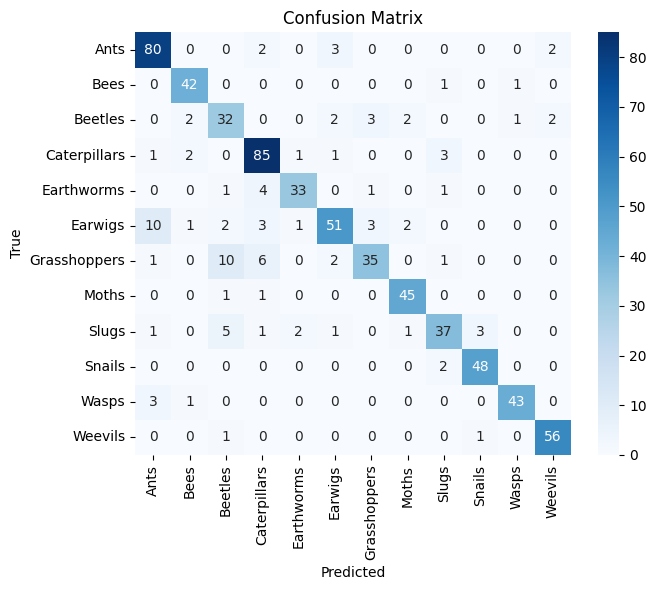

In [ ]:
trainResNet50Model(*setupResnet50Transfer("cropped_dataset", "transfer"))

Training The Data Imbalanced Sets

In [5]:
# Raw Model Training On Imbalanced Data
detector = YOLO("yolo11n.yaml") # Create a new model from YAML

detector.train(data='imbalanced_dataset/data.yaml', 
               epochs=100, 
               imgsz=640, 
               batch=16, 
               name='yolo_imbalanced_raw_model', 
               device=0, 
               patience=50, 
               pretrained=False,
               hsv_h=0.015,
               hsv_s=0.7,
               hsv_v=0.4,
               degrees=90, 
               translate=0.2,
               scale=0.5,
               shear=20,
               perspective=0.0,
               flipud=1,
               fliplr=1,
               bgr=0.0,
               mosaic=1.0,
               mixup=0.0,
               cutmix=0.0,
               copy_paste=0.0,
               copy_paste_mode = 'flip',
               auto_augment = 'randaugment',
               erasing=0.4,
               ) # Train the mode

detector = YOLO("runs/detect/yolo_imbalanced_raw_model/weights/best.pt")
metrics = detector.val()
print(metrics)

New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.228 🚀 Python-3.13.9 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX 3500 Ada Generation Laptop GPU, 11874MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=imbalanced_dataset/data.yaml, degrees=90, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=1, flipud=1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_imba

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4611.1±1807.8 MB/s, size: 47.0 KB)
train: Scanning /home/cormac/cv/imbalanced_dataset/train/labels... 11502 images, 2288 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 11502/11502 6.0Kit/s 1.9s<0.0s
train: New cache created: /home/cormac/cv/imbalanced_dataset/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2904.0±1475.2 MB/s, size: 34.1 KB)
val: Scanning /home/cormac/cv/imbalanced_dataset/valid/labels... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 2.7Kit/s 0.4s1ss
val: New cache created: /home/cormac/cv/imbalanced_dataset/valid/labels.cache
Plotting labels to /home/cormac/cv/runs/detect/yolo_imbalanced_raw_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      1/100      3.59G      3.002      4.468      4.205         43        640: 0% ──────────── 1/719 2.6it/s 4.6s<4:41

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      1/100       3.7G      3.062      4.671      4.185         25        640: 100% ━━━━━━━━━━━━ 719/719 12.1it/s 59.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 6.8it/s 5.2s<0.1s
                   all       1095       1341    0.00208      0.389    0.00266   0.000779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      2/100      3.82G       2.78       4.54      4.025         32        640: 0% ──────────── 1/719 2.0it/s 0.1s<5:51

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      2/100      3.82G      2.334      4.253      3.086         36        640: 100% ━━━━━━━━━━━━ 719/719 14.4it/s 49.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.5s0.1s
                   all       1095       1341      0.271      0.155     0.0233    0.00675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      3/100      3.82G      1.886       4.13      2.502         26        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:08

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      3/100      3.82G      1.815      3.708      2.412         42        640: 100% ━━━━━━━━━━━━ 719/719 14.3it/s 50.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.9it/s 2.5s0.1s
                   all       1095       1341      0.355      0.146      0.018     0.0055

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      4/100      3.82G      1.895      3.607      2.264         35        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:42

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      4/100      3.82G       1.75      3.425      2.297         23        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.4s0.1s
                   all       1095       1341      0.547      0.136     0.0396     0.0131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      5/100      3.82G      1.775      3.355      2.279         45        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:41

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      5/100      3.82G      1.694      3.285      2.227         37        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.7it/s 2.6s0.1s
                   all       1095       1341      0.564     0.0545     0.0251    0.00707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      6/100      3.82G      1.809      3.644      2.352         28        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:15

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      6/100      3.82G      1.651      3.225      2.201         30        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.5it/s 2.6s0.1s
                   all       1095       1341      0.435      0.162     0.0759     0.0331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      7/100      3.82G      1.865      3.186      2.262         56        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:16

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      7/100      3.82G      1.609      3.152      2.168         27        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.5s0.1s
                   all       1095       1341      0.589      0.154     0.0933     0.0305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      8/100      3.82G      1.625      3.153      2.204         36        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:34

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      8/100      3.82G      1.592       3.09      2.143         38        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.443      0.169      0.129     0.0489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      9/100      3.82G      1.511      2.891      2.061         39        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:35

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      9/100      3.82G      1.572      3.028      2.126         30        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.521      0.205       0.15     0.0615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     10/100      3.82G      1.471      2.883      2.095         46        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     10/100      3.82G      1.556      2.978      2.102         24        640: 100% ━━━━━━━━━━━━ 719/719 13.7it/s 52.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.6it/s 2.6s0.1s
                   all       1095       1341      0.499      0.176      0.168     0.0715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     11/100      3.82G      1.388      2.685      1.984         31        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:15

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     11/100      3.99G       1.55      2.933      2.091         34        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.467      0.212      0.179     0.0795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     12/100      3.99G      1.623       3.03      2.204         50        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:35

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     12/100      3.99G      1.531      2.896      2.084         40        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.7it/s 2.5s0.1s
                   all       1095       1341      0.501      0.218        0.2      0.084

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     13/100      3.99G      1.482      2.655      2.023         46        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:39

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     13/100      3.99G      1.517      2.861      2.062         35        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.526      0.208      0.197     0.0875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     14/100      3.99G      1.451      2.889       1.98         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     14/100      3.99G      1.505      2.811      2.053         47        640: 100% ━━━━━━━━━━━━ 719/719 14.1it/s 51.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.513      0.268      0.226     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     15/100      3.99G       1.39      2.866       2.08         33        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     15/100      3.99G      1.508        2.8      2.055         44        640: 100% ━━━━━━━━━━━━ 719/719 14.1it/s 51.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.775      0.219      0.235      0.099

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     16/100      3.99G      1.542      2.856      2.091         35        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:34

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     16/100      3.99G      1.496      2.746      2.043         33        640: 100% ━━━━━━━━━━━━ 719/719 14.1it/s 51.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.606       0.27      0.275      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     17/100      3.99G      1.637      2.759      2.211         56        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:37

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     17/100      3.99G      1.477      2.712      2.027         71        640: 100% ━━━━━━━━━━━━ 719/719 14.1it/s 51.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.578      0.293      0.282      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     18/100      3.99G      1.602      3.071      2.221         50        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     18/100      3.99G      1.478      2.687       2.02         29        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.693      0.289      0.306      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     19/100      3.99G      1.642      2.977      2.171         36        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     19/100      3.99G      1.465      2.655      2.016         42        640: 100% ━━━━━━━━━━━━ 719/719 14.1it/s 51.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341       0.56      0.339      0.346       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     20/100      3.99G      1.573      2.986      2.152         46        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     20/100      3.99G      1.462      2.632      2.006         36        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.637      0.337      0.345      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     21/100      3.99G      1.444      2.522      2.025         34        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:35

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     21/100      3.99G      1.454      2.605      1.998         36        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.569      0.321      0.326      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     22/100      3.99G      1.517      2.444      2.085         46        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     22/100      3.99G      1.452      2.582       1.99         40        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.4s0.1s
                   all       1095       1341      0.614      0.354      0.369      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     23/100      3.99G       1.24      2.348      1.842         39        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     23/100      3.99G      1.443      2.539      1.983         37        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.4s0.1s
                   all       1095       1341      0.614      0.363      0.374      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     24/100      3.99G      1.399      2.615      1.916         39        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     24/100      3.99G      1.444      2.526      1.977         38        640: 100% ━━━━━━━━━━━━ 719/719 14.1it/s 51.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.743      0.346      0.388      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     25/100      3.99G      1.498      2.597      1.972         35        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:36

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     25/100      3.99G      1.434      2.477      1.964         32        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.618      0.376      0.402      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     26/100      3.99G      1.348      2.425      1.833         43        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     26/100      3.99G      1.422       2.46      1.959         40        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.683       0.37      0.416      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     27/100      3.99G      1.403       2.46      1.942         39        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     27/100      3.99G      1.423      2.435       1.96         30        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.5s0.1s
                   all       1095       1341      0.682      0.393      0.437      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     28/100      3.99G      1.328      2.387       1.92         44        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:30

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     28/100      3.99G      1.422      2.415      1.953         32        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.688      0.383      0.433      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     29/100      3.99G       1.31      2.315      1.842         31        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:39

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     29/100      3.99G      1.406       2.39      1.945         25        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.7it/s 2.6s0.1s
                   all       1095       1341      0.681      0.408      0.454      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     30/100      3.99G      1.311      2.199      1.922         46        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:19

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     30/100      3.99G      1.407      2.371       1.95         38        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.9it/s 2.5s0.1s
                   all       1095       1341      0.696      0.405      0.459      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     31/100      3.99G      1.362      2.375      1.923         50        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:22

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     31/100      3.99G       1.41      2.353      1.944         28        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.0it/s 2.5s0.1s
                   all       1095       1341      0.781      0.403      0.488      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     32/100         4G       1.43      2.332      1.927         33        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:44

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     32/100         4G      1.399      2.333      1.941         31        640: 100% ━━━━━━━━━━━━ 719/719 13.7it/s 52.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.761      0.403      0.486       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     33/100         4G      1.343      2.176      1.904         42        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:39

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     33/100         4G      1.402      2.316      1.936         46        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 53.0s<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.0it/s 2.5s0.1s
                   all       1095       1341      0.754      0.399      0.499      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     34/100         4G      1.543      2.531      1.988         47        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:19

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     34/100         4G      1.392      2.304      1.932         41        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.0it/s 2.5s0.1s
                   all       1095       1341      0.717      0.424      0.501      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     35/100         4G       1.34      2.172      1.935         32        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:19

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     35/100         4G      1.386      2.269      1.927         46        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.699      0.427      0.481      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     36/100         4G      1.376      2.236      1.925         45        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:32

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     36/100         4G      1.384      2.268      1.919         41        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.716      0.427      0.497       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     37/100         4G      1.415      2.331      1.945         36        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:38

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     37/100         4G      1.387      2.256      1.928         29        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.762      0.412      0.511      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     38/100         4G      1.516      2.315      2.014         36        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     38/100         4G      1.377      2.221      1.914         42        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.766      0.418      0.526      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     39/100         4G      1.334      2.296      1.845         38        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     39/100         4G      1.364      2.218      1.915         38        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.746      0.429      0.524      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     40/100         4G      1.353      1.928      1.849         42        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:35

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     40/100         4G      1.363      2.179      1.903         43        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.759      0.431      0.517      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     41/100         4G      1.312      2.381       1.91         34        640: 0% ──────────── 1/719 2.0it/s 0.1s<5:55

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     41/100         4G      1.371      2.193      1.913         46        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.768      0.446      0.548      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     42/100         4G      1.287      2.376      1.838         49        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     42/100         4G      1.367      2.163      1.902         38        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.749      0.453      0.543      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     43/100         4G      1.434      2.447      1.916         42        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     43/100         4G      1.357      2.152      1.899         70        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.745      0.438      0.539      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     44/100         4G      1.422      2.278      1.988         46        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:42

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     44/100         4G      1.356      2.125      1.889         32        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.751      0.458      0.542      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     45/100         4G      1.441      2.014      1.974         44        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:36

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     45/100         4G      1.351      2.108      1.888         32        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.749      0.454      0.547      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     46/100         4G      1.408      2.121      1.923         44        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     46/100         4G      1.354      2.105      1.892         38        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.763      0.457       0.56      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     47/100         4G      1.293      2.045      1.789         35        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     47/100         4G      1.351      2.105      1.886         37        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.1it/s 2.3s0.1s
                   all       1095       1341      0.736      0.463      0.566       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     48/100         4G      1.425      2.287      1.897         31        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:32

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     48/100         4G      1.334      2.081      1.873         38        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.797      0.442       0.56       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     49/100         4G      1.363      1.895      1.887         34        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:40

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     49/100         4G      1.329      2.063      1.866         26        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.8it/s 2.4s0.1s
                   all       1095       1341      0.759      0.456      0.557      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     50/100         4G      1.301      2.045      1.886         37        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     50/100         4G      1.336      2.069       1.87         38        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.778      0.456      0.571      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     51/100         4G      1.418      2.155      1.919         42        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     51/100         4G      1.334      2.054      1.874         36        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.773      0.455      0.574      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     52/100         4G      1.447      2.244       1.98         42        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:39

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     52/100         4G      1.336      2.039      1.867         28        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.758      0.463       0.57      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     53/100         4G      1.427      1.938      1.914         57        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:39

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     53/100         4G      1.328      2.023      1.861         33        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.4s0.1s
                   all       1095       1341      0.755      0.464      0.576        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     54/100         4G       1.29      1.881      1.859         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     54/100         4G      1.322      2.022      1.851         23        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.797      0.464      0.587      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     55/100         4G      1.272      1.893      1.882         36        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:38

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     55/100         4G      1.325      2.015       1.86         34        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.793       0.47      0.586       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     56/100         4G       1.27      2.134      1.812         36        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     56/100         4G      1.322      1.993      1.853         42        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341        0.8      0.464      0.592      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     57/100         4G      1.238      1.742        1.8         38        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:40

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     57/100         4G      1.321      1.989      1.858         41        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.824      0.458      0.593      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     58/100         4G      1.358      2.113      1.845         42        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     58/100         4G      1.312      1.978      1.848         26        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.808       0.47      0.599      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     59/100         4G       1.39      2.046      1.875         58        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:15

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     59/100         4G       1.31      1.964      1.844         56        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341       0.78      0.487      0.599      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     60/100         4G      1.438      2.171      1.918         66        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:42

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     60/100         4G      1.307      1.965      1.837         46        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.793      0.475      0.603      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     61/100         4G      1.351      1.919      1.862         48        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:41

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     61/100         4G      1.298      1.948      1.842         44        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.793      0.478      0.603      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     62/100         4G      1.492      2.252       2.02         50        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     62/100         4G      1.312      1.935      1.846         36        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.808      0.474      0.607      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     63/100         4G      1.494      2.234      1.944         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     63/100         4G      1.294      1.932      1.837         40        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.769      0.485      0.607      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     64/100         4G      1.292      1.922      1.869         52        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:34

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     64/100         4G      1.298      1.914      1.838         32        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.777      0.499       0.61      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     65/100         4G      1.356      2.011      1.914         52        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:40

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     65/100         4G      1.291      1.895      1.827         42        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.791      0.495      0.615      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     66/100         4G       1.36      1.984      1.851         44        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     66/100         4G      1.291      1.896      1.833         32        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341       0.79      0.491      0.614      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     67/100         4G       1.28      2.009      1.811         33        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     67/100         4G      1.297      1.908      1.832         28        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.803      0.492      0.614      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     68/100         4G      1.415      2.024      1.972         45        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:34

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     68/100         4G      1.295      1.872      1.827         49        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.811      0.493      0.618      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     69/100         4G      1.385      2.031      1.868         40        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:37

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     69/100         4G      1.284      1.882      1.821         36        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.826      0.492      0.618      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     70/100         4G      1.329      1.738      1.844         49        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     70/100         4G      1.289      1.857      1.828         33        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.839      0.494      0.625      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     71/100         4G      1.288      1.988      1.779         35        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     71/100         4G      1.275      1.851      1.811         37        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.8it/s 2.4s0.1s
                   all       1095       1341      0.826      0.496      0.624       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     72/100         4G      1.077      1.652      1.623         46        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:30

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     72/100         4G      1.282      1.837      1.813         31        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 12.9it/s 2.7s0.2s
                   all       1095       1341       0.83      0.495      0.625      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     73/100         4G      1.306      1.688      1.831         45        640: 0% ──────────── 1/719 2.0it/s 0.1s<5:57

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     73/100         4G      1.275      1.823      1.813         28        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.824      0.498      0.627      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     74/100         4G      1.305      1.909      1.786         37        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:17

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     74/100         4G      1.272      1.823      1.807         38        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.1it/s 2.5s0.1s
                   all       1095       1341      0.825      0.503      0.626      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     75/100         4G      1.311      2.053      1.881         40        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:36

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     75/100         4G      1.274      1.815      1.806         42        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.829      0.503      0.626      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     76/100         4G      1.301      1.762      1.823         35        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:39

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     76/100         4G      1.277      1.812      1.809         38        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.7s<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.1it/s 2.5s0.1s
                   all       1095       1341      0.839      0.503      0.627      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     77/100         4G      1.294      1.736      1.834         40        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:47

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     77/100         4G      1.269      1.787      1.803         35        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.835      0.508      0.629      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     78/100         4G      1.312      1.908      1.861         34        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:22

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     78/100         4G      1.259      1.776      1.798         33        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.0it/s 2.5s0.1s
                   all       1095       1341       0.84      0.503       0.63      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     79/100         4G      1.262      1.793      1.771         47        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:21

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     79/100         4G      1.254      1.765      1.796         32        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.848        0.5      0.631      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     80/100         4G      1.323      1.796      1.861         37        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:45

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     80/100         4G      1.264      1.783      1.798         47        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.851      0.503      0.632      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     81/100         4G      1.315      1.908       1.83         47        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:41

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     81/100         4G      1.256       1.77      1.793         45        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.849      0.502      0.633      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     82/100         4G      1.321      1.784      1.899         48        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:16

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     82/100         4G      1.245      1.752      1.789         38        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.8it/s 2.4s0.1s
                   all       1095       1341      0.849      0.502      0.632       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     83/100         4G      1.255      1.953       1.77         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:15

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     83/100         4G      1.252      1.756      1.789         55        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.851      0.503      0.632       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     84/100         4G      1.244      1.615      1.797         37        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     84/100         4G       1.25      1.744      1.789         35        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.8it/s 2.4s0.1s
                   all       1095       1341      0.848      0.503      0.632      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     85/100         4G       1.22      1.825      1.747         51        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:34

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     85/100         4G      1.247      1.723      1.784         29        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.849      0.502      0.631      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     86/100         4G      1.101      1.608      1.728         32        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:17

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     86/100         4G      1.245      1.729      1.783         39        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.856      0.504      0.632      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     87/100         4G      1.214       1.75      1.735         45        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     87/100         4G      1.244      1.724       1.78         44        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.852      0.504      0.634      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     88/100         4G      1.231      1.547      1.805         50        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:37

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     88/100         4G      1.234       1.71      1.773         46        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.853      0.502      0.635      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     89/100         4G      1.195      1.663       1.72         39        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:43

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     89/100         4G      1.236      1.692      1.774         37        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.857      0.502      0.635      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     90/100         4G      1.179      1.636      1.796         35        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:16

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     90/100         4G      1.236      1.703      1.777         38        640: 100% ━━━━━━━━━━━━ 719/719 14.0it/s 51.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.8it/s 2.4s0.1s
                   all       1095       1341      0.855      0.508      0.637      0.354
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     91/100         4G      1.166      1.271       2.12         12        640: 0% ──────────── 0/719  0.2s

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     91/100         4G      1.062      1.111      1.814         11        640: 100% ━━━━━━━━━━━━ 719/719 14.1it/s 51.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.8it/s 2.4s0.1s
                   all       1095       1341      0.855      0.507      0.637      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     92/100         4G       0.79     0.7451      1.616         15        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:36

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     92/100         4G      1.045      1.054      1.794         13        640: 100% ━━━━━━━━━━━━ 719/719 14.3it/s 50.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.856      0.508      0.637      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     93/100         4G       1.12      1.017      1.782         14        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:40

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     93/100         4G      1.041      1.031      1.789          9        640: 100% ━━━━━━━━━━━━ 719/719 14.3it/s 50.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.3it/s 2.3s0.1s
                   all       1095       1341      0.859      0.506       0.64      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     94/100         4G      1.002      1.012      1.871         27        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     94/100         4G      1.019       1.02      1.775         14        640: 100% ━━━━━━━━━━━━ 719/719 14.3it/s 50.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.0it/s 2.3s0.1s
                   all       1095       1341      0.854      0.509       0.64      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     95/100         4G      0.808     0.6236      1.601         17        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     95/100         4G      1.015      1.005      1.767         12        640: 100% ━━━━━━━━━━━━ 719/719 14.3it/s 50.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.9it/s 2.3s0.1s
                   all       1095       1341      0.849      0.512      0.642      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     96/100         4G      1.264      1.197      1.837         18        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:35

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     96/100         4G      1.023      1.005       1.77         11        640: 100% ━━━━━━━━━━━━ 719/719 14.3it/s 50.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.0it/s 2.3s0.1s
                   all       1095       1341      0.848      0.511      0.643      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     97/100         4G     0.9224     0.7869      1.814         14        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:30

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     97/100         4G      1.002     0.9842      1.751         17        640: 100% ━━━━━━━━━━━━ 719/719 14.3it/s 50.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.8it/s 2.4s0.1s
                   all       1095       1341      0.849       0.51      0.643      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     98/100         4G     0.6038     0.6299      1.391         14        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     98/100         4G      1.001     0.9731      1.754         13        640: 100% ━━━━━━━━━━━━ 719/719 14.2it/s 50.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.9it/s 2.4s0.1s
                   all       1095       1341      0.849       0.51      0.644      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     99/100         4G      1.019      0.804       1.73         14        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:19

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     99/100         4G     0.9966     0.9599      1.747         14        640: 100% ━━━━━━━━━━━━ 719/719 14.3it/s 50.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.9it/s 2.4s0.1s
                   all       1095       1341      0.844       0.51      0.645       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    100/100         4G     0.9284     0.9059      1.597         22        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:31

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

    100/100         4G     0.9887     0.9636      1.742         12        640: 100% ━━━━━━━━━━━━ 719/719 14.2it/s 50.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.0it/s 2.3s0.1s
                   all       1095       1341      0.845      0.511      0.647      0.361

100 epochs completed in 1.506 hours.
Optimizer stripped from /home/cormac/cv/runs/detect/yolo_imbalanced_raw_model/weights/last.pt, 5.5MB
Optimizer stripped from /home/cormac/cv/runs/detect/yolo_imbalanced_raw_model/weights/best.pt, 5.5MB

Validating /home/cormac/cv/runs/detect/yolo_imbalanced_raw_model/weights/best.pt...
Ultralytics 8.3.228 🚀 Python-3.13.9 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX 3500 Ada Generation Laptop GPU, 11874MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 12.9it/s 2.7s0.1s

Transfer Model Training on Imbalanced Data

In [ ]:
# Raw Model Training On Imbalanced Data
detector = YOLO("yolo11n.pt") # Create a new model from YAML

detector.train(data='imbalanced_dataset/data.yaml', 
               epochs=100, 
               imgsz=640, 
               batch=16, 
               name='yolo_imbalanced_transfer_model', 
               device=0, 
               patience=50, 
               pretrained=True,
               hsv_h=0.015,
               hsv_s=0.7,
               hsv_v=0.4,
               degrees=90, 
               translate=0.2,
               scale=0.5,
               shear=20,
               perspective=0.0,
               flipud=1,
               fliplr=1,
               bgr=0.0,
               mosaic=1.0,
               mixup=0.0,
               cutmix=0.0,
               copy_paste=0.0,
               copy_paste_mode = 'flip',
               auto_augment = 'randaugment',
               erasing=0.4,
               ) # Train the mode

detector = YOLO("runs/detect/yolo_imbalanced_transfer_model/weights/best.pt")
metrics = detector.val()
print(metrics)

New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.228 🚀 Python-3.13.9 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX 3500 Ada Generation Laptop GPU, 11874MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=imbalanced_dataset/data.yaml, degrees=90, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=1, flipud=1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_imbala

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

train: Scanning /home/cormac/cv/imbalanced_dataset/train/labels.cache... 11502 images, 2288 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 11502/11502 36.0Mit/s 0.0s
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 192.6±112.8 MB/s, size: 36.6 KB)
val: Scanning /home/cormac/cv/imbalanced_dataset/valid/labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 2.3Mit/s 0.0s0s
Plotting labels to /home/cormac/cv/runs/detect/yolo_imbalanced_raw_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/cormac/cv/runs/detect/yolo_imbalanced_raw_model2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances   

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      1/100      2.61G      2.241      4.045      2.669         66        640: 0% ──────────── 0/719  0.6s

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      1/100      2.84G      1.703      3.983      2.151         25        640: 100% ━━━━━━━━━━━━ 719/719 12.7it/s 56.8s<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 12.8it/s 2.7s0.1s
                   all       1095       1341      0.496      0.254      0.187     0.0615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      2/100      2.84G      1.507      3.212      2.032         32        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:31

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      2/100      2.84G       1.56      3.255      2.026         36        640: 100% ━━━━━━━━━━━━ 719/719 13.5it/s 53.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.1it/s 2.5s0.1s
                   all       1095       1341      0.477      0.245      0.202     0.0734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      3/100      2.84G      1.419      3.344      1.964         26        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      3/100      2.95G      1.578      3.095      2.045         42        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.352      0.127     0.0604     0.0178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      4/100      2.95G       1.65      3.182      2.003         35        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:34

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      4/100      2.95G      1.599      2.973      2.063         23        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.6it/s 2.6s0.1s
                   all       1095       1341      0.497       0.25      0.225     0.0773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      5/100      2.95G      1.683      2.902      2.102         45        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:44

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      5/100      2.95G      1.563      2.768      2.024         37        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.648      0.296        0.3      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      6/100      2.95G      1.692      3.054       2.08         28        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      6/100      2.95G      1.543      2.665      2.006         30        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.685      0.319      0.347      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      7/100      2.95G       1.79      2.481       2.14         56        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      7/100      2.95G      1.513      2.567      1.977         27        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.586      0.325      0.328       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      8/100      2.95G      1.445      2.709      1.894         36        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:38

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      8/100      2.95G        1.5       2.49      1.961         38        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.648      0.377      0.402      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      9/100      2.95G      1.346      2.279      1.876         39        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:37

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      9/100      2.95G      1.479      2.428      1.944         30        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.652      0.376      0.393      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     10/100      2.95G      1.456      2.379      1.948         46        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     10/100      2.95G      1.457      2.364      1.926         24        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.627      0.375      0.386      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     11/100      2.95G      1.333      1.981      1.826         31        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:16

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     11/100      3.12G      1.456      2.325      1.928         34        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.4s0.1s
                   all       1095       1341       0.69       0.38      0.444      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     12/100      3.12G      1.588      2.242      2.012         50        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:35

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     12/100      3.12G      1.435      2.254      1.909         40        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.736      0.366      0.451      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     13/100      3.12G      1.434      2.125      1.887         46        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:35

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     13/100      3.12G      1.428      2.229        1.9         35        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.696      0.411      0.464      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     14/100      3.12G      1.459      2.243       1.93         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:15

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     14/100      3.12G      1.412       2.19       1.89         47        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.719        0.4      0.479      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     15/100      3.12G      1.476      2.195      1.965         33        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     15/100      3.12G      1.422       2.16      1.887         44        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.696      0.431       0.49      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     16/100      3.12G      1.478      2.067       1.91         35        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:35

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     16/100      3.12G      1.404      2.121      1.873         33        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.768      0.427      0.518      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     17/100      3.12G      1.472      2.092      1.996         56        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:38

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     17/100      3.12G      1.393       2.07      1.866         71        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.744      0.447      0.526      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     18/100      3.12G      1.504      2.432      1.986         50        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     18/100      3.12G      1.391      2.068      1.858         29        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.779      0.432      0.531      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     19/100      3.12G      1.562      2.331      1.945         36        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:16

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     19/100      3.12G      1.393      2.049      1.863         42        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.797      0.432      0.533       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     20/100      3.12G      1.529      2.303      1.981         46        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:37

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     20/100      3.12G      1.386      2.033      1.854         36        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.771      0.457      0.556      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     21/100      3.12G      1.345      1.824      1.839         34        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:41

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     21/100      3.12G      1.378      2.004      1.849         36        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.779      0.458      0.566      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     22/100      3.12G      1.329      1.943      1.891         46        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     22/100      3.12G      1.373      1.997      1.845         40        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
                   all       1095       1341      0.808      0.453      0.567      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     23/100      3.12G       1.24      1.913      1.765         39        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     23/100      3.12G      1.368       1.97      1.842         37        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.805      0.467      0.579      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     24/100      3.12G      1.337      1.933      1.767         39        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:34

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     24/100      3.12G      1.367      1.957      1.837         38        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.7it/s 2.4s0.1s
                   all       1095       1341      0.805      0.478        0.6      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     25/100      3.12G      1.314      2.033      1.765         35        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:38

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     25/100      3.12G      1.359      1.914       1.83         32        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 53.0s<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.782      0.494      0.595      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     26/100      3.12G      1.269      1.918      1.725         43        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     26/100      3.12G      1.347       1.91      1.818         40        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.8it/s 2.4s0.1s
                   all       1095       1341      0.799      0.485       0.61       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     27/100      3.12G      1.365      2.024      1.827         39        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     27/100      3.12G      1.349      1.896      1.826         30        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.815      0.488      0.611      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     28/100      3.12G      1.234      1.816       1.73         44        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:39

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     28/100      3.12G      1.345      1.876      1.819         32        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 11.7it/s 3.0s0.1s
                   all       1095       1341      0.796      0.497      0.611      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     29/100      3.12G      1.304      1.843      1.793         31        640: 0% ──────────── 1/719 1.7it/s 0.2s<7:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     29/100      3.12G      1.333       1.87       1.81         25        640: 100% ━━━━━━━━━━━━ 719/719 13.2it/s 54.6s<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.0it/s 2.7s0.1s
                   all       1095       1341      0.824      0.476      0.615      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     30/100      3.12G      1.223      1.773      1.802         46        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:19

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     30/100      3.12G      1.332       1.86      1.811         38        640: 100% ━━━━━━━━━━━━ 719/719 13.5it/s 53.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.1it/s 2.5s0.1s
                   all       1095       1341      0.794      0.494      0.623      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     31/100      3.12G      1.225      1.869      1.764         50        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:17

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     31/100      3.12G      1.336      1.839      1.807         28        640: 100% ━━━━━━━━━━━━ 719/719 13.3it/s 53.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.7it/s 2.5s0.1s
                   all       1095       1341      0.786      0.518      0.635      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     32/100      3.12G      1.227      1.975      1.742         33        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:45

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     32/100      3.12G       1.32      1.818      1.796         31        640: 100% ━━━━━━━━━━━━ 719/719 13.3it/s 54.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.9it/s 2.5s0.1s
                   all       1095       1341      0.827      0.494      0.624       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     33/100      3.12G      1.287      1.732      1.798         42        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:41

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     33/100      3.12G      1.326      1.814      1.801         46        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 53.0s<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.6it/s 2.6s0.1s
                   all       1095       1341      0.798      0.513      0.636      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     34/100      3.12G      1.442      1.985       1.83         47        640: 0% ──────────── 1/719 2.0it/s 0.1s<5:58

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     34/100      3.12G      1.317      1.797      1.793         41        640: 100% ━━━━━━━━━━━━ 719/719 13.2it/s 54.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.3it/s 2.6s0.1s
                   all       1095       1341       0.83      0.507      0.649      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     35/100      3.12G       1.26      1.678      1.752         32        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     35/100      3.12G      1.312       1.78      1.789         46        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.7it/s 2.6s0.1s
                   all       1095       1341      0.819      0.512      0.634      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     36/100      3.12G       1.32       1.79      1.813         45        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:44

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     36/100      3.12G      1.304      1.772      1.784         41        640: 100% ━━━━━━━━━━━━ 719/719 13.7it/s 52.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.4s0.1s
                   all       1095       1341      0.814      0.519      0.651      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     37/100      3.12G      1.348      1.866      1.807         36        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:43

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     37/100      3.12G      1.309      1.763      1.788         29        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.846      0.512      0.656      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     38/100      3.12G      1.464      1.772      1.896         36        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     38/100      3.12G      1.302      1.732      1.777         42        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.853      0.514      0.668      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     39/100      3.12G      1.359       1.78      1.775         38        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:25

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     39/100      3.12G      1.292      1.732      1.776         38        640: 100% ━━━━━━━━━━━━ 719/719 13.7it/s 52.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.849      0.507      0.659      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     40/100      3.12G      1.202      1.505      1.718         42        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     40/100      3.12G      1.286      1.703      1.766         43        640: 100% ━━━━━━━━━━━━ 719/719 13.9it/s 51.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.857       0.52       0.67      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     41/100      3.12G      1.257      1.971      1.761         34        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:44

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     41/100      3.12G      1.293      1.731      1.775         46        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 51.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.868      0.518      0.679      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     42/100      3.12G       1.15      1.757      1.662         49        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     42/100      3.12G      1.287      1.685       1.77         38        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.877      0.524      0.679       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     43/100      3.12G      1.351       1.88      1.802         42        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:17

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     43/100      3.12G       1.28      1.696      1.763         70        640: 100% ━━━━━━━━━━━━ 719/719 13.5it/s 53.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.1it/s 2.5s0.1s
                   all       1095       1341      0.865      0.518      0.681      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     44/100      3.12G      1.306      1.675      1.818         46        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:42

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     44/100      3.12G      1.279      1.678      1.758         32        640: 100% ━━━━━━━━━━━━ 719/719 13.5it/s 53.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.7it/s 2.5s0.1s
                   all       1095       1341       0.88      0.514      0.684      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     45/100      3.12G      1.372      1.683      1.783         44        640: 0% ──────────── 1/719 1.9it/s 0.2s<6:23

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     45/100      3.12G      1.271       1.66      1.754         32        640: 100% ━━━━━━━━━━━━ 719/719 13.5it/s 53.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.859      0.512      0.672      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     46/100      3.12G      1.322      1.811      1.785         44        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:16

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     46/100      3.12G      1.276      1.658      1.757         38        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.883      0.512      0.681      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     47/100      3.12G      1.162      1.557      1.667         35        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     47/100      3.12G      1.277      1.649      1.754         37        640: 100% ━━━━━━━━━━━━ 719/719 13.0it/s 55.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.7it/s 2.6s0.1s
                   all       1095       1341       0.85      0.534       0.68      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     48/100      3.12G       1.33       1.79       1.78         31        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:43

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     48/100      3.12G      1.255      1.621       1.74         38        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 53.0s<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.3it/s 2.4s0.1s
                   all       1095       1341      0.838      0.533      0.681      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     49/100      3.12G      1.248      1.631      1.722         34        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:45

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     49/100      3.12G      1.252      1.608      1.733         26        640: 100% ━━━━━━━━━━━━ 719/719 13.8it/s 52.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341      0.881      0.529      0.686      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     50/100      3.12G      1.162      1.564      1.716         37        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     50/100      3.12G      1.266       1.62      1.743         38        640: 100% ━━━━━━━━━━━━ 719/719 13.6it/s 52.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.5it/s 2.3s0.1s
                   all       1095       1341      0.875      0.535      0.695      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     51/100      3.12G      1.355      1.734      1.807         42        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     51/100      3.12G      1.258      1.616      1.744         36        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.883      0.535      0.699      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     52/100      3.12G      1.411      1.637      1.866         42        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:25

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     52/100      3.12G      1.255      1.593      1.735         28        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.2s0.1s
                   all       1095       1341      0.888      0.532      0.701      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     53/100      3.12G      1.275       1.46      1.721         57        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:30

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     53/100      3.12G      1.255      1.581      1.729         33        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.856      0.545      0.703      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     54/100      3.12G      1.211      1.428       1.72         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:06

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     54/100      3.12G      1.247      1.583      1.723         23        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.878      0.535      0.696      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     55/100      3.12G      1.215      1.467      1.744         36        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     55/100      3.12G      1.249      1.583      1.729         34        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.882       0.53      0.697      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     56/100      3.12G      1.187       1.69      1.707         36        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:23

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     56/100      3.12G      1.238      1.562      1.723         42        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.888      0.526      0.697      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     57/100      3.12G      1.113      1.359      1.638         38        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:34

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     57/100      3.12G      1.244       1.54      1.725         41        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.6it/s 2.4s0.1s
                   all       1095       1341      0.898      0.533      0.711      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     58/100      3.12G      1.281      1.623      1.759         42        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     58/100      3.12G      1.238      1.537       1.72         26        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.903      0.525      0.708      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     59/100      3.12G      1.381      1.557      1.801         58        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:17

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     59/100      3.12G      1.235      1.534      1.719         56        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.891      0.529      0.704      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     60/100      3.12G      1.249      1.502      1.691         37        640: 0% ──────────── 0/719  0.1s

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     60/100      3.12G      1.229      1.536      1.711         46        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.6it/s 2.2s0.1s
                   all       1095       1341      0.898      0.532      0.711       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     61/100      3.12G      1.316      1.468      1.731         48        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:31

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     61/100      3.12G      1.223       1.52       1.71         44        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.902      0.532      0.712      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     62/100      3.12G      1.398      1.854      1.891         50        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     62/100      3.12G       1.23      1.512      1.715         36        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.888      0.544      0.715      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     63/100      3.12G      1.347      1.735      1.758         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:08

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     63/100      3.12G      1.214      1.498      1.702         40        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.2it/s 2.3s0.1s
                   all       1095       1341      0.874      0.546      0.715      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     64/100      3.12G      1.194      1.371      1.651         52        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:24

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     64/100      3.12G      1.217      1.478      1.702         32        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.887      0.541      0.714      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     65/100      3.12G      1.274       1.57      1.791         52        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:40

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     65/100      3.12G      1.213      1.464      1.691         42        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.2s0.1s
                   all       1095       1341      0.891      0.545      0.718      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     66/100      3.12G      1.242      1.507      1.711         44        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     66/100      3.12G      1.212      1.462      1.695         32        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.2s0.1s
                   all       1095       1341      0.895      0.542      0.718      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     67/100      3.12G      1.232      1.563      1.754         33        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:08

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     67/100      3.12G       1.22      1.473      1.695         28        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.893      0.545      0.718      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     68/100      3.12G      1.276      1.644      1.767         45        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:24

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     68/100      3.12G      1.207      1.443      1.685         49        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.889      0.544      0.717      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     69/100      3.12G      1.246      1.431      1.741         40        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:36

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     69/100      3.12G      1.203       1.45      1.689         36        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.886      0.545      0.716      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     70/100      3.12G      1.223      1.453      1.663         49        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     70/100      3.12G      1.207      1.434      1.689         33        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.2s0.1s
                   all       1095       1341      0.901      0.545       0.72      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     71/100      3.12G      1.186       1.33      1.626         35        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:05

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     71/100      3.12G      1.194      1.428      1.678         37        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.914      0.536      0.721      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     72/100      3.12G      1.048      1.341      1.558         46        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:24

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     72/100      3.12G      1.196      1.411      1.677         31        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.907      0.541      0.725      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     73/100      3.12G      1.332      1.305       1.77         45        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:32

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     73/100      3.12G       1.19      1.403      1.674         28        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.897      0.542      0.723      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     74/100      3.12G      1.241      1.357      1.639         37        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:08

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     74/100      3.12G      1.193      1.405      1.674         38        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.898      0.543      0.721      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     75/100      3.12G      1.277      1.644      1.804         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:07

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     75/100      3.12G      1.187      1.396      1.671         42        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.895      0.543      0.722      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     76/100      3.12G      1.135      1.361      1.637         35        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:26

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     76/100      3.12G      1.185      1.392      1.669         38        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.888      0.545      0.722      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     77/100      3.12G      1.232      1.358      1.698         40        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:27

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     77/100      3.12G      1.181      1.373      1.664         35        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.883      0.544      0.717      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     78/100      3.12G      1.246      1.536      1.712         34        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     78/100      3.12G      1.171      1.364      1.659         33        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.884      0.545      0.714      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     79/100      3.12G      1.113      1.401      1.608         47        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:05

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     79/100      3.12G      1.162      1.356      1.658         32        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.893      0.538      0.716      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     80/100      3.12G      1.291      1.474      1.822         37        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:25

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     80/100      3.12G      1.173      1.358      1.656         47        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.2s0.1s
                   all       1095       1341      0.893      0.539      0.716      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     81/100      3.12G      1.124       1.38      1.599         47        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:32

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     81/100      3.12G      1.168      1.347      1.654         45        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.891      0.538      0.714      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     82/100      3.12G      1.145      1.243      1.627         48        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     82/100      3.12G      1.153      1.332      1.644         38        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.893       0.54      0.715      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     83/100      3.12G      1.154      1.426      1.622         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     83/100      3.12G      1.155      1.337      1.645         55        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.903      0.536      0.714      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     84/100      3.12G      1.152      1.175      1.638         37        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:25

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     84/100      3.12G      1.155      1.325      1.641         35        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.907      0.536      0.712      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     85/100      3.12G      1.065       1.34      1.574         51        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:31

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     85/100      3.12G      1.151      1.305       1.64         29        640: 100% ━━━━━━━━━━━━ 719/719 14.4it/s 49.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.908      0.535      0.712      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     86/100      3.12G     0.9169      1.135      1.571         32        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:05

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     86/100      3.12G       1.15       1.32      1.636         39        640: 100% ━━━━━━━━━━━━ 719/719 14.5it/s 49.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.9it/s 2.4s0.1s
                   all       1095       1341      0.901      0.537      0.713      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     87/100      3.12G      1.064      1.294      1.607         45        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     87/100      3.12G      1.146      1.308      1.634         44        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.902      0.539      0.714      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     88/100      3.12G      1.147      1.167      1.617         50        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:30

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     88/100      3.12G      1.139      1.295      1.631         46        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.5it/s 2.3s0.1s
                   all       1095       1341      0.894      0.537       0.71      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     89/100      3.12G       1.11      1.248      1.605         39        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:37

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     89/100      3.12G      1.133      1.271      1.622         37        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.2s0.1s
                   all       1095       1341      0.898      0.537       0.71      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     90/100      3.12G      1.062      1.223       1.67         35        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:07

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     90/100      3.12G      1.133      1.289      1.624         38        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.2it/s 2.3s0.1s
                   all       1095       1341      0.887      0.542      0.709      0.408
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     91/100      3.12G       0.82     0.7171      1.718         12        640: 0% ──────────── 0/719  0.3s

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     91/100      3.12G     0.9384     0.7239       1.63         11        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.884      0.543      0.708      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     92/100      3.12G      0.639     0.5174      1.395         15        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:22

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     92/100      3.12G     0.9212     0.6634      1.604         13        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.5s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.886      0.541      0.706      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     93/100      3.12G      1.119     0.6622      1.723         14        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:29

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     93/100      3.12G     0.9193     0.6524      1.602          9        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.891      0.537      0.706      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     94/100      3.12G     0.8196     0.5627      1.573         27        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:04

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     94/100      3.12G     0.8981     0.6355      1.586         14        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341       0.89      0.536      0.704      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     95/100      3.12G     0.7194     0.4155      1.446         17        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:05

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     95/100      3.12G     0.8861     0.6291      1.571         12        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.889      0.538      0.702       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     96/100      3.12G      1.238     0.8138      1.761         18        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:27

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     96/100      3.12G     0.8934     0.6224      1.573         11        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.887      0.539      0.702       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     97/100      3.12G     0.7843     0.5557       1.55         14        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:26

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     97/100      3.12G     0.8758     0.6093      1.559         17        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.2s0.1s
                   all       1095       1341      0.886      0.539      0.701      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     98/100      3.12G     0.5568     0.3418      1.295         14        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:07

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     98/100      3.12G     0.8681     0.6034      1.551         13        640: 100% ━━━━━━━━━━━━ 719/719 15.0it/s 48.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.886      0.539        0.7       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     99/100      3.12G      0.799      0.541      1.442         14        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:01

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     99/100      3.12G     0.8704     0.5986      1.552         14        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.5it/s 2.1s0.1s
                   all       1095       1341      0.886      0.539      0.699       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    100/100      3.12G     0.8159     0.4525      1.434         22        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:24

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

    100/100      3.12G     0.8576     0.5901      1.545         12        640: 100% ━━━━━━━━━━━━ 719/719 15.0it/s 48.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.882       0.54      0.695      0.409

100 epochs completed in 1.475 hours.
Optimizer stripped from /home/cormac/cv/runs/detect/yolo_imbalanced_raw_model2/weights/last.pt, 5.5MB
Optimizer stripped from /home/cormac/cv/runs/detect/yolo_imbalanced_raw_model2/weights/best.pt, 5.5MB

Validating /home/cormac/cv/runs/detect/yolo_imbalanced_raw_model2/weights/best.pt...
Ultralytics 8.3.228 🚀 Python-3.13.9 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX 3500 Ada Generation Laptop GPU, 11874MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.4it/s 2.6s0

Resnet Raw Imbalanced Data

In [7]:
trainResNet50Model(*setupResnet50Raw("cropped_imbalanced_dataset", "imbalanced_raw"))

MEAN: tensor([0.4962, 0.4582, 0.3457])
STD: tensor([0.1959, 0.1938, 0.1825])


Epoch 1/70: 100%|██████████| 389/389 [00:43<00:00,  9.01it/s]


Epoch 1/70
Train Loss: 2.3513
Val Loss:   2.7945
Val Acc:    18.87%

Epoch 1/70
Train Loss: 2.3513
Val Loss:   2.7945
Val Acc:    18.87%



Epoch 2/70: 100%|██████████| 389/389 [00:43<00:00,  8.99it/s]


Epoch 2/70
Train Loss: 2.1657
Val Loss:   2.6466
Val Acc:    21.48%

Epoch 2/70
Train Loss: 2.1657
Val Loss:   2.6466
Val Acc:    21.48%



Epoch 3/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 3/70
Train Loss: 2.0868
Val Loss:   2.6431
Val Acc:    26.85%

Epoch 3/70
Train Loss: 2.0868
Val Loss:   2.6431
Val Acc:    26.85%



Epoch 4/70: 100%|██████████| 389/389 [00:43<00:00,  8.92it/s]


Epoch 4/70
Train Loss: 2.0056
Val Loss:   2.4475
Val Acc:    31.32%

Epoch 4/70
Train Loss: 2.0056
Val Loss:   2.4475
Val Acc:    31.32%



Epoch 5/70: 100%|██████████| 389/389 [00:43<00:00,  8.88it/s]


Epoch 5/70
Train Loss: 1.9315
Val Loss:   2.4259
Val Acc:    33.71%

Epoch 5/70
Train Loss: 1.9315
Val Loss:   2.4259
Val Acc:    33.71%



Epoch 6/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 6/70
Train Loss: 1.8510
Val Loss:   2.2717
Val Acc:    37.29%

Epoch 6/70
Train Loss: 1.8510
Val Loss:   2.2717
Val Acc:    37.29%



Epoch 7/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 7/70
Train Loss: 1.7823
Val Loss:   2.5565
Val Acc:    35.42%

Epoch 7/70
Train Loss: 1.7823
Val Loss:   2.5565
Val Acc:    35.42%



Epoch 8/70: 100%|██████████| 389/389 [00:43<00:00,  8.88it/s]


Epoch 8/70
Train Loss: 1.7439
Val Loss:   2.1685
Val Acc:    40.64%

Epoch 8/70
Train Loss: 1.7439
Val Loss:   2.1685
Val Acc:    40.64%



Epoch 9/70: 100%|██████████| 389/389 [00:43<00:00,  8.86it/s]


Epoch 9/70
Train Loss: 1.6931
Val Loss:   2.0247
Val Acc:    39.60%

Epoch 9/70
Train Loss: 1.6931
Val Loss:   2.0247
Val Acc:    39.60%



Epoch 10/70: 100%|██████████| 389/389 [00:43<00:00,  8.88it/s]


Epoch 10/70
Train Loss: 1.6320
Val Loss:   2.2624
Val Acc:    39.82%

Epoch 10/70
Train Loss: 1.6320
Val Loss:   2.2624
Val Acc:    39.82%



Epoch 11/70: 100%|██████████| 389/389 [00:43<00:00,  8.87it/s]


Epoch 11/70
Train Loss: 1.5932
Val Loss:   2.1429
Val Acc:    40.12%

Epoch 11/70
Train Loss: 1.5932
Val Loss:   2.1429
Val Acc:    40.12%



Epoch 12/70: 100%|██████████| 389/389 [00:43<00:00,  8.87it/s]


Epoch 12/70
Train Loss: 1.5555
Val Loss:   2.1262
Val Acc:    42.51%

Epoch 12/70
Train Loss: 1.5555
Val Loss:   2.1262
Val Acc:    42.51%



Epoch 13/70: 100%|██████████| 389/389 [00:43<00:00,  8.88it/s]


Epoch 13/70
Train Loss: 1.5032
Val Loss:   2.0338
Val Acc:    47.28%

Epoch 13/70
Train Loss: 1.5032
Val Loss:   2.0338
Val Acc:    47.28%



Epoch 14/70: 100%|██████████| 389/389 [00:43<00:00,  8.86it/s]


Epoch 14/70
Train Loss: 1.4753
Val Loss:   1.8658
Val Acc:    50.11%

Epoch 14/70
Train Loss: 1.4753
Val Loss:   1.8658
Val Acc:    50.11%



Epoch 15/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 15/70
Train Loss: 1.4199
Val Loss:   1.9803
Val Acc:    48.55%

Epoch 15/70
Train Loss: 1.4199
Val Loss:   1.9803
Val Acc:    48.55%



Epoch 16/70: 100%|██████████| 389/389 [00:43<00:00,  8.88it/s]


Epoch 16/70
Train Loss: 1.3865
Val Loss:   1.9029
Val Acc:    47.35%

Epoch 16/70
Train Loss: 1.3865
Val Loss:   1.9029
Val Acc:    47.35%



Epoch 17/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 17/70
Train Loss: 1.3414
Val Loss:   1.7565
Val Acc:    50.26%

Epoch 17/70
Train Loss: 1.3414
Val Loss:   1.7565
Val Acc:    50.26%



Epoch 18/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 18/70
Train Loss: 1.3268
Val Loss:   1.8513
Val Acc:    51.68%

Epoch 18/70
Train Loss: 1.3268
Val Loss:   1.8513
Val Acc:    51.68%



Epoch 19/70: 100%|██████████| 389/389 [00:43<00:00,  8.86it/s]


Epoch 19/70
Train Loss: 1.2911
Val Loss:   2.0314
Val Acc:    48.77%

Epoch 19/70
Train Loss: 1.2911
Val Loss:   2.0314
Val Acc:    48.77%



Epoch 20/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 20/70
Train Loss: 1.2469
Val Loss:   1.8030
Val Acc:    53.99%

Epoch 20/70
Train Loss: 1.2469
Val Loss:   1.8030
Val Acc:    53.99%



Epoch 21/70: 100%|██████████| 389/389 [00:43<00:00,  8.89it/s]


Epoch 21/70
Train Loss: 1.2084
Val Loss:   1.6446
Val Acc:    55.56%

Epoch 21/70
Train Loss: 1.2084
Val Loss:   1.6446
Val Acc:    55.56%



Epoch 22/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 22/70
Train Loss: 1.1809
Val Loss:   1.9319
Val Acc:    52.50%

Epoch 22/70
Train Loss: 1.1809
Val Loss:   1.9319
Val Acc:    52.50%



Epoch 23/70: 100%|██████████| 389/389 [00:43<00:00,  8.91it/s]


Epoch 23/70
Train Loss: 1.1529
Val Loss:   1.6744
Val Acc:    55.11%

Epoch 23/70
Train Loss: 1.1529
Val Loss:   1.6744
Val Acc:    55.11%



Epoch 24/70: 100%|██████████| 389/389 [00:43<00:00,  8.87it/s]


Epoch 24/70
Train Loss: 1.1346
Val Loss:   1.5527
Val Acc:    56.75%

Epoch 24/70
Train Loss: 1.1346
Val Loss:   1.5527
Val Acc:    56.75%



Epoch 25/70: 100%|██████████| 389/389 [00:43<00:00,  8.91it/s]


Epoch 25/70
Train Loss: 1.1066
Val Loss:   1.6706
Val Acc:    55.93%

Epoch 25/70
Train Loss: 1.1066
Val Loss:   1.6706
Val Acc:    55.93%



Epoch 26/70: 100%|██████████| 389/389 [00:43<00:00,  8.87it/s]


Epoch 26/70
Train Loss: 1.0837
Val Loss:   1.8763
Val Acc:    54.36%

Epoch 26/70
Train Loss: 1.0837
Val Loss:   1.8763
Val Acc:    54.36%



Epoch 27/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 27/70
Train Loss: 1.0579
Val Loss:   2.0577
Val Acc:    52.65%

Epoch 27/70
Train Loss: 1.0579
Val Loss:   2.0577
Val Acc:    52.65%



Epoch 28/70: 100%|██████████| 389/389 [00:43<00:00,  8.87it/s]


Epoch 28/70
Train Loss: 1.0247
Val Loss:   1.6789
Val Acc:    56.52%

Epoch 28/70
Train Loss: 1.0247
Val Loss:   1.6789
Val Acc:    56.52%



Epoch 29/70: 100%|██████████| 389/389 [00:43<00:00,  8.84it/s]


Epoch 29/70
Train Loss: 1.0073
Val Loss:   1.6252
Val Acc:    58.84%

Epoch 29/70
Train Loss: 1.0073
Val Loss:   1.6252
Val Acc:    58.84%



Epoch 30/70: 100%|██████████| 389/389 [00:43<00:00,  8.86it/s]


Epoch 30/70
Train Loss: 0.9714
Val Loss:   1.5381
Val Acc:    60.55%

Epoch 30/70
Train Loss: 0.9714
Val Loss:   1.5381
Val Acc:    60.55%



Epoch 31/70: 100%|██████████| 389/389 [00:43<00:00,  8.85it/s]


Epoch 31/70
Train Loss: 0.9785
Val Loss:   1.6146
Val Acc:    60.18%

Epoch 31/70
Train Loss: 0.9785
Val Loss:   1.6146
Val Acc:    60.18%



Epoch 32/70: 100%|██████████| 389/389 [00:43<00:00,  8.88it/s]


Epoch 32/70
Train Loss: 0.9387
Val Loss:   1.4898
Val Acc:    61.22%

Epoch 32/70
Train Loss: 0.9387
Val Loss:   1.4898
Val Acc:    61.22%



Epoch 33/70: 100%|██████████| 389/389 [00:44<00:00,  8.82it/s]


Epoch 33/70
Train Loss: 0.9135
Val Loss:   1.6766
Val Acc:    57.27%

Epoch 33/70
Train Loss: 0.9135
Val Loss:   1.6766
Val Acc:    57.27%



Epoch 34/70: 100%|██████████| 389/389 [00:43<00:00,  8.91it/s]


Epoch 34/70
Train Loss: 0.8873
Val Loss:   1.5499
Val Acc:    60.85%

Epoch 34/70
Train Loss: 0.8873
Val Loss:   1.5499
Val Acc:    60.85%



Epoch 35/70: 100%|██████████| 389/389 [00:43<00:00,  8.93it/s]


Epoch 35/70
Train Loss: 0.8804
Val Loss:   1.4366
Val Acc:    61.67%

Epoch 35/70
Train Loss: 0.8804
Val Loss:   1.4366
Val Acc:    61.67%



Epoch 36/70: 100%|██████████| 389/389 [00:43<00:00,  8.92it/s]


Epoch 36/70
Train Loss: 0.8754
Val Loss:   1.4499
Val Acc:    63.68%

Epoch 36/70
Train Loss: 0.8754
Val Loss:   1.4499
Val Acc:    63.68%



Epoch 37/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 37/70
Train Loss: 0.8497
Val Loss:   1.3713
Val Acc:    61.07%

Epoch 37/70
Train Loss: 0.8497
Val Loss:   1.3713
Val Acc:    61.07%



Epoch 38/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 38/70
Train Loss: 0.8439
Val Loss:   1.5617
Val Acc:    62.34%

Epoch 38/70
Train Loss: 0.8439
Val Loss:   1.5617
Val Acc:    62.34%



Epoch 39/70: 100%|██████████| 389/389 [00:43<00:00,  8.94it/s]


Epoch 39/70
Train Loss: 0.8256
Val Loss:   1.3819
Val Acc:    63.46%

Epoch 39/70
Train Loss: 0.8256
Val Loss:   1.3819
Val Acc:    63.46%



Epoch 40/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 40/70
Train Loss: 0.7943
Val Loss:   1.6575
Val Acc:    61.30%

Epoch 40/70
Train Loss: 0.7943
Val Loss:   1.6575
Val Acc:    61.30%



Epoch 41/70: 100%|██████████| 389/389 [00:43<00:00,  8.90it/s]


Epoch 41/70
Train Loss: 0.7994
Val Loss:   1.2886
Val Acc:    66.59%

Epoch 41/70
Train Loss: 0.7994
Val Loss:   1.2886
Val Acc:    66.59%



Epoch 42/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 42/70
Train Loss: 0.7922
Val Loss:   1.3489
Val Acc:    65.32%

Epoch 42/70
Train Loss: 0.7922
Val Loss:   1.3489
Val Acc:    65.32%



Epoch 43/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 43/70
Train Loss: 0.7578
Val Loss:   1.4254
Val Acc:    62.71%

Epoch 43/70
Train Loss: 0.7578
Val Loss:   1.4254
Val Acc:    62.71%



Epoch 44/70: 100%|██████████| 389/389 [00:43<00:00,  8.93it/s]


Epoch 44/70
Train Loss: 0.7471
Val Loss:   1.6267
Val Acc:    61.07%

Epoch 44/70
Train Loss: 0.7471
Val Loss:   1.6267
Val Acc:    61.07%



Epoch 45/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 45/70
Train Loss: 0.7453
Val Loss:   1.3364
Val Acc:    66.07%

Epoch 45/70
Train Loss: 0.7453
Val Loss:   1.3364
Val Acc:    66.07%



Epoch 46/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 46/70
Train Loss: 0.7358
Val Loss:   1.3525
Val Acc:    65.55%

Epoch 46/70
Train Loss: 0.7358
Val Loss:   1.3525
Val Acc:    65.55%



Epoch 47/70: 100%|██████████| 389/389 [00:43<00:00,  8.92it/s]


Epoch 47/70
Train Loss: 0.7107
Val Loss:   1.3654
Val Acc:    65.62%

Epoch 47/70
Train Loss: 0.7107
Val Loss:   1.3654
Val Acc:    65.62%



Epoch 48/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 48/70
Train Loss: 0.7201
Val Loss:   1.3122
Val Acc:    67.64%

Epoch 48/70
Train Loss: 0.7201
Val Loss:   1.3122
Val Acc:    67.64%



Epoch 49/70: 100%|██████████| 389/389 [00:43<00:00,  8.88it/s]


Epoch 49/70
Train Loss: 0.7026
Val Loss:   1.3964
Val Acc:    64.95%

Epoch 49/70
Train Loss: 0.7026
Val Loss:   1.3964
Val Acc:    64.95%



Epoch 50/70: 100%|██████████| 389/389 [00:43<00:00,  8.92it/s]


Epoch 50/70
Train Loss: 0.6952
Val Loss:   1.4280
Val Acc:    65.85%

Epoch 50/70
Train Loss: 0.6952
Val Loss:   1.4280
Val Acc:    65.85%



Epoch 51/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 51/70
Train Loss: 0.6694
Val Loss:   1.3889
Val Acc:    66.22%

Epoch 51/70
Train Loss: 0.6694
Val Loss:   1.3889
Val Acc:    66.22%



Epoch 52/70: 100%|██████████| 389/389 [00:43<00:00,  8.92it/s]


Epoch 52/70
Train Loss: 0.6704
Val Loss:   1.3715
Val Acc:    65.70%

Epoch 52/70
Train Loss: 0.6704
Val Loss:   1.3715
Val Acc:    65.70%



Epoch 53/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 53/70
Train Loss: 0.6563
Val Loss:   1.3272
Val Acc:    67.49%

Epoch 53/70
Train Loss: 0.6563
Val Loss:   1.3272
Val Acc:    67.49%



Epoch 54/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 54/70
Train Loss: 0.6671
Val Loss:   1.3730
Val Acc:    67.56%

Epoch 54/70
Train Loss: 0.6671
Val Loss:   1.3730
Val Acc:    67.56%



Epoch 55/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 55/70
Train Loss: 0.6344
Val Loss:   1.3570
Val Acc:    66.14%

Epoch 55/70
Train Loss: 0.6344
Val Loss:   1.3570
Val Acc:    66.14%



Epoch 56/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 56/70
Train Loss: 0.6541
Val Loss:   1.2473
Val Acc:    67.56%

Epoch 56/70
Train Loss: 0.6541
Val Loss:   1.2473
Val Acc:    67.56%



Epoch 57/70: 100%|██████████| 389/389 [00:43<00:00,  8.93it/s]


Epoch 57/70
Train Loss: 0.6201
Val Loss:   1.3079
Val Acc:    67.71%

Epoch 57/70
Train Loss: 0.6201
Val Loss:   1.3079
Val Acc:    67.71%



Epoch 58/70: 100%|██████████| 389/389 [00:43<00:00,  8.94it/s]


Epoch 58/70
Train Loss: 0.6208
Val Loss:   1.3867
Val Acc:    67.26%

Epoch 58/70
Train Loss: 0.6208
Val Loss:   1.3867
Val Acc:    67.26%



Epoch 59/70: 100%|██████████| 389/389 [00:43<00:00,  8.94it/s]


Epoch 59/70
Train Loss: 0.6046
Val Loss:   1.2256
Val Acc:    68.98%

Epoch 59/70
Train Loss: 0.6046
Val Loss:   1.2256
Val Acc:    68.98%



Epoch 60/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 60/70
Train Loss: 0.5962
Val Loss:   1.4230
Val Acc:    66.59%

Epoch 60/70
Train Loss: 0.5962
Val Loss:   1.4230
Val Acc:    66.59%



Epoch 61/70: 100%|██████████| 389/389 [00:43<00:00,  8.93it/s]


Epoch 61/70
Train Loss: 0.5978
Val Loss:   1.4312
Val Acc:    66.59%

Epoch 61/70
Train Loss: 0.5978
Val Loss:   1.4312
Val Acc:    66.59%



Epoch 62/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 62/70
Train Loss: 0.5824
Val Loss:   1.3627
Val Acc:    68.61%

Epoch 62/70
Train Loss: 0.5824
Val Loss:   1.3627
Val Acc:    68.61%



Epoch 63/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 63/70
Train Loss: 0.5722
Val Loss:   1.4822
Val Acc:    67.04%

Epoch 63/70
Train Loss: 0.5722
Val Loss:   1.4822
Val Acc:    67.04%



Epoch 64/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 64/70
Train Loss: 0.5824
Val Loss:   1.4224
Val Acc:    68.53%

Epoch 64/70
Train Loss: 0.5824
Val Loss:   1.4224
Val Acc:    68.53%



Epoch 65/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 65/70
Train Loss: 0.5559
Val Loss:   1.3599
Val Acc:    69.13%

Epoch 65/70
Train Loss: 0.5559
Val Loss:   1.3599
Val Acc:    69.13%



Epoch 66/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 66/70
Train Loss: 0.5535
Val Loss:   1.4280
Val Acc:    66.89%

Epoch 66/70
Train Loss: 0.5535
Val Loss:   1.4280
Val Acc:    66.89%



Epoch 67/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 67/70
Train Loss: 0.5514
Val Loss:   1.4377
Val Acc:    67.11%

Epoch 67/70
Train Loss: 0.5514
Val Loss:   1.4377
Val Acc:    67.11%



Epoch 68/70: 100%|██████████| 389/389 [00:43<00:00,  8.93it/s]


Epoch 68/70
Train Loss: 0.5390
Val Loss:   1.1838
Val Acc:    70.62%

Epoch 68/70
Train Loss: 0.5390
Val Loss:   1.1838
Val Acc:    70.62%



Epoch 69/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 69/70
Train Loss: 0.5255
Val Loss:   1.2570
Val Acc:    70.25%

Epoch 69/70
Train Loss: 0.5255
Val Loss:   1.2570
Val Acc:    70.25%



Epoch 70/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 70/70
Train Loss: 0.5189
Val Loss:   1.3205
Val Acc:    70.32%

Epoch 70/70
Train Loss: 0.5189
Val Loss:   1.3205
Val Acc:    70.32%


===== Classification Report =====

              precision    recall  f1-score   support

        Ants       0.67      0.78      0.72        87
        Bees       0.75      0.89      0.81        44
     Beetles       0.50      0.11      0.19        44
Caterpillars       0.69      0.63      0.66        93
  Earthworms       0.78      0.70      0.74        40
     Earwigs       0.58      0.25      0.35        73
Grasshoppers       0.42      0.67      0.51        55
       Moths       0.80      0.87      0.84        47
       Slugs       0.80      0.24      0.36        51
      Snails       0.62      0.96      0.75        50
       Wasps       0.82      0.98      0.89        47
     Weevils       0.67      0.97      0.79        58

    accuracy                           0.66       689
   macro avg       0.67      0.67      0.63       689
weighted avg

Resnet Transfer Imbalanced Data

In [13]:
trainResNet50Model(*setupResnet50Transfer("cropped_imbalanced_dataset", "imbalanced_transfer"))


Epoch 1/70: 100%|██████████| 389/389 [00:42<00:00,  9.17it/s]


Epoch 1/70
Train Loss: 1.2822
Val Loss:   0.7093
Val Acc:    79.42%

Epoch 1/70
Train Loss: 1.2822
Val Loss:   0.7093
Val Acc:    79.42%



Epoch 2/70: 100%|██████████| 389/389 [00:43<00:00,  9.04it/s]


Epoch 2/70
Train Loss: 0.4674
Val Loss:   0.5602
Val Acc:    85.16%

Epoch 2/70
Train Loss: 0.4674
Val Loss:   0.5602
Val Acc:    85.16%



Epoch 3/70: 100%|██████████| 389/389 [00:43<00:00,  9.00it/s]


Epoch 3/70
Train Loss: 0.3756
Val Loss:   0.5403
Val Acc:    85.76%

Epoch 3/70
Train Loss: 0.3756
Val Loss:   0.5403
Val Acc:    85.76%



Epoch 4/70: 100%|██████████| 389/389 [00:43<00:00,  9.00it/s]


Epoch 4/70
Train Loss: 0.3098
Val Loss:   0.6103
Val Acc:    84.86%

Epoch 4/70
Train Loss: 0.3098
Val Loss:   0.6103
Val Acc:    84.86%



Epoch 5/70: 100%|██████████| 389/389 [00:43<00:00,  8.99it/s]


Epoch 5/70
Train Loss: 0.2762
Val Loss:   0.5311
Val Acc:    86.95%

Epoch 5/70
Train Loss: 0.2762
Val Loss:   0.5311
Val Acc:    86.95%



Epoch 6/70: 100%|██████████| 389/389 [00:43<00:00,  8.98it/s]


Epoch 6/70
Train Loss: 0.2503
Val Loss:   0.6383
Val Acc:    84.56%

Epoch 6/70
Train Loss: 0.2503
Val Loss:   0.6383
Val Acc:    84.56%



Epoch 7/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 7/70
Train Loss: 0.2317
Val Loss:   0.6277
Val Acc:    85.53%

Epoch 7/70
Train Loss: 0.2317
Val Loss:   0.6277
Val Acc:    85.53%



Epoch 8/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 8/70
Train Loss: 0.2216
Val Loss:   0.6038
Val Acc:    85.38%

Epoch 8/70
Train Loss: 0.2216
Val Loss:   0.6038
Val Acc:    85.38%



Epoch 9/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 9/70
Train Loss: 0.1980
Val Loss:   0.6692
Val Acc:    85.38%

Epoch 9/70
Train Loss: 0.1980
Val Loss:   0.6692
Val Acc:    85.38%



Epoch 10/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 10/70
Train Loss: 0.1772
Val Loss:   0.6370
Val Acc:    85.98%

Epoch 10/70
Train Loss: 0.1772
Val Loss:   0.6370
Val Acc:    85.98%



Epoch 11/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 11/70
Train Loss: 0.1839
Val Loss:   0.6380
Val Acc:    85.68%

Epoch 11/70
Train Loss: 0.1839
Val Loss:   0.6380
Val Acc:    85.68%



Epoch 12/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 12/70
Train Loss: 0.1729
Val Loss:   0.6664
Val Acc:    84.71%

Epoch 12/70
Train Loss: 0.1729
Val Loss:   0.6664
Val Acc:    84.71%



Epoch 13/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 13/70
Train Loss: 0.1601
Val Loss:   0.6649
Val Acc:    84.27%

Epoch 13/70
Train Loss: 0.1601
Val Loss:   0.6649
Val Acc:    84.27%



Epoch 14/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 14/70
Train Loss: 0.1539
Val Loss:   0.6289
Val Acc:    86.50%

Epoch 14/70
Train Loss: 0.1539
Val Loss:   0.6289
Val Acc:    86.50%



Epoch 15/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 15/70
Train Loss: 0.1552
Val Loss:   0.6354
Val Acc:    85.98%

Epoch 15/70
Train Loss: 0.1552
Val Loss:   0.6354
Val Acc:    85.98%



Epoch 16/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 16/70
Train Loss: 0.1637
Val Loss:   0.6925
Val Acc:    86.20%

Epoch 16/70
Train Loss: 0.1637
Val Loss:   0.6925
Val Acc:    86.20%



Epoch 17/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 17/70
Train Loss: 0.1432
Val Loss:   0.6859
Val Acc:    85.01%

Epoch 17/70
Train Loss: 0.1432
Val Loss:   0.6859
Val Acc:    85.01%



Epoch 18/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 18/70
Train Loss: 0.1459
Val Loss:   0.7393
Val Acc:    85.09%

Epoch 18/70
Train Loss: 0.1459
Val Loss:   0.7393
Val Acc:    85.09%



Epoch 19/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 19/70
Train Loss: 0.1387
Val Loss:   0.7741
Val Acc:    84.79%

Epoch 19/70
Train Loss: 0.1387
Val Loss:   0.7741
Val Acc:    84.79%



Epoch 20/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 20/70
Train Loss: 0.1277
Val Loss:   0.8322
Val Acc:    84.04%

Epoch 20/70
Train Loss: 0.1277
Val Loss:   0.8322
Val Acc:    84.04%



Epoch 21/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 21/70
Train Loss: 0.1341
Val Loss:   0.7630
Val Acc:    85.76%

Epoch 21/70
Train Loss: 0.1341
Val Loss:   0.7630
Val Acc:    85.76%



Epoch 22/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 22/70
Train Loss: 0.1271
Val Loss:   0.7436
Val Acc:    85.23%

Epoch 22/70
Train Loss: 0.1271
Val Loss:   0.7436
Val Acc:    85.23%



Epoch 23/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 23/70
Train Loss: 0.1213
Val Loss:   0.7689
Val Acc:    84.86%

Epoch 23/70
Train Loss: 0.1213
Val Loss:   0.7689
Val Acc:    84.86%



Epoch 24/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 24/70
Train Loss: 0.1206
Val Loss:   0.8646
Val Acc:    84.71%

Epoch 24/70
Train Loss: 0.1206
Val Loss:   0.8646
Val Acc:    84.71%



Epoch 25/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 25/70
Train Loss: 0.1177
Val Loss:   0.7544
Val Acc:    86.35%

Epoch 25/70
Train Loss: 0.1177
Val Loss:   0.7544
Val Acc:    86.35%



Epoch 26/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 26/70
Train Loss: 0.1197
Val Loss:   0.7701
Val Acc:    86.13%

Epoch 26/70
Train Loss: 0.1197
Val Loss:   0.7701
Val Acc:    86.13%



Epoch 27/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 27/70
Train Loss: 0.1033
Val Loss:   0.8573
Val Acc:    85.38%

Epoch 27/70
Train Loss: 0.1033
Val Loss:   0.8573
Val Acc:    85.38%



Epoch 28/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 28/70
Train Loss: 0.1153
Val Loss:   0.7405
Val Acc:    86.20%

Epoch 28/70
Train Loss: 0.1153
Val Loss:   0.7405
Val Acc:    86.20%



Epoch 29/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 29/70
Train Loss: 0.1041
Val Loss:   0.9449
Val Acc:    83.52%

Epoch 29/70
Train Loss: 0.1041
Val Loss:   0.9449
Val Acc:    83.52%



Epoch 30/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 30/70
Train Loss: 0.1129
Val Loss:   0.8407
Val Acc:    85.38%

Epoch 30/70
Train Loss: 0.1129
Val Loss:   0.8407
Val Acc:    85.38%



Epoch 31/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 31/70
Train Loss: 0.1066
Val Loss:   0.7948
Val Acc:    85.98%

Epoch 31/70
Train Loss: 0.1066
Val Loss:   0.7948
Val Acc:    85.98%



Epoch 32/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 32/70
Train Loss: 0.1055
Val Loss:   1.0344
Val Acc:    84.41%

Epoch 32/70
Train Loss: 0.1055
Val Loss:   1.0344
Val Acc:    84.41%



Epoch 33/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 33/70
Train Loss: 0.1076
Val Loss:   0.7936
Val Acc:    84.49%

Epoch 33/70
Train Loss: 0.1076
Val Loss:   0.7936
Val Acc:    84.49%



Epoch 34/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 34/70
Train Loss: 0.1020
Val Loss:   0.7417
Val Acc:    86.58%

Epoch 34/70
Train Loss: 0.1020
Val Loss:   0.7417
Val Acc:    86.58%



Epoch 35/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 35/70
Train Loss: 0.1095
Val Loss:   0.8821
Val Acc:    84.49%

Epoch 35/70
Train Loss: 0.1095
Val Loss:   0.8821
Val Acc:    84.49%



Epoch 36/70: 100%|██████████| 389/389 [00:43<00:00,  8.98it/s]


Epoch 36/70
Train Loss: 0.0966
Val Loss:   0.8804
Val Acc:    85.46%

Epoch 36/70
Train Loss: 0.0966
Val Loss:   0.8804
Val Acc:    85.46%



Epoch 37/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 37/70
Train Loss: 0.0953
Val Loss:   0.9164
Val Acc:    83.97%

Epoch 37/70
Train Loss: 0.0953
Val Loss:   0.9164
Val Acc:    83.97%



Epoch 38/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 38/70
Train Loss: 0.0993
Val Loss:   0.7534
Val Acc:    86.20%

Epoch 38/70
Train Loss: 0.0993
Val Loss:   0.7534
Val Acc:    86.20%



Epoch 39/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 39/70
Train Loss: 0.0961
Val Loss:   0.9484
Val Acc:    84.86%

Epoch 39/70
Train Loss: 0.0961
Val Loss:   0.9484
Val Acc:    84.86%



Epoch 40/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 40/70
Train Loss: 0.0900
Val Loss:   0.8742
Val Acc:    84.79%

Epoch 40/70
Train Loss: 0.0900
Val Loss:   0.8742
Val Acc:    84.79%



Epoch 41/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 41/70
Train Loss: 0.0905
Val Loss:   0.9305
Val Acc:    85.61%

Epoch 41/70
Train Loss: 0.0905
Val Loss:   0.9305
Val Acc:    85.61%



Epoch 42/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 42/70
Train Loss: 0.0915
Val Loss:   0.9237
Val Acc:    84.64%

Epoch 42/70
Train Loss: 0.0915
Val Loss:   0.9237
Val Acc:    84.64%



Epoch 43/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 43/70
Train Loss: 0.0876
Val Loss:   0.9743
Val Acc:    85.01%

Epoch 43/70
Train Loss: 0.0876
Val Loss:   0.9743
Val Acc:    85.01%



Epoch 44/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 44/70
Train Loss: 0.0997
Val Loss:   0.8653
Val Acc:    85.91%

Epoch 44/70
Train Loss: 0.0997
Val Loss:   0.8653
Val Acc:    85.91%



Epoch 45/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 45/70
Train Loss: 0.0804
Val Loss:   0.8879
Val Acc:    83.82%

Epoch 45/70
Train Loss: 0.0804
Val Loss:   0.8879
Val Acc:    83.82%



Epoch 46/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 46/70
Train Loss: 0.0933
Val Loss:   0.9319
Val Acc:    83.97%

Epoch 46/70
Train Loss: 0.0933
Val Loss:   0.9319
Val Acc:    83.97%



Epoch 47/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 47/70
Train Loss: 0.0916
Val Loss:   1.0119
Val Acc:    84.04%

Epoch 47/70
Train Loss: 0.0916
Val Loss:   1.0119
Val Acc:    84.04%



Epoch 48/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 48/70
Train Loss: 0.0898
Val Loss:   0.9696
Val Acc:    83.74%

Epoch 48/70
Train Loss: 0.0898
Val Loss:   0.9696
Val Acc:    83.74%



Epoch 49/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 49/70
Train Loss: 0.0872
Val Loss:   0.8915
Val Acc:    84.41%

Epoch 49/70
Train Loss: 0.0872
Val Loss:   0.8915
Val Acc:    84.41%



Epoch 50/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 50/70
Train Loss: 0.0836
Val Loss:   0.9433
Val Acc:    84.79%

Epoch 50/70
Train Loss: 0.0836
Val Loss:   0.9433
Val Acc:    84.79%



Epoch 51/70: 100%|██████████| 389/389 [00:43<00:00,  8.95it/s]


Epoch 51/70
Train Loss: 0.0830
Val Loss:   0.9833
Val Acc:    83.89%

Epoch 51/70
Train Loss: 0.0830
Val Loss:   0.9833
Val Acc:    83.89%



Epoch 52/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 52/70
Train Loss: 0.0789
Val Loss:   0.9602
Val Acc:    84.86%

Epoch 52/70
Train Loss: 0.0789
Val Loss:   0.9602
Val Acc:    84.86%



Epoch 53/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 53/70
Train Loss: 0.0798
Val Loss:   1.0613
Val Acc:    83.67%

Epoch 53/70
Train Loss: 0.0798
Val Loss:   1.0613
Val Acc:    83.67%



Epoch 54/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 54/70
Train Loss: 0.0889
Val Loss:   0.8892
Val Acc:    84.71%

Epoch 54/70
Train Loss: 0.0889
Val Loss:   0.8892
Val Acc:    84.71%



Epoch 55/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 55/70
Train Loss: 0.0742
Val Loss:   0.9180
Val Acc:    84.64%

Epoch 55/70
Train Loss: 0.0742
Val Loss:   0.9180
Val Acc:    84.64%



Epoch 56/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 56/70
Train Loss: 0.0737
Val Loss:   1.0263
Val Acc:    84.41%

Epoch 56/70
Train Loss: 0.0737
Val Loss:   1.0263
Val Acc:    84.41%



Epoch 57/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 57/70
Train Loss: 0.0824
Val Loss:   1.0776
Val Acc:    84.04%

Epoch 57/70
Train Loss: 0.0824
Val Loss:   1.0776
Val Acc:    84.04%



Epoch 58/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 58/70
Train Loss: 0.0780
Val Loss:   0.9214
Val Acc:    85.91%

Epoch 58/70
Train Loss: 0.0780
Val Loss:   0.9214
Val Acc:    85.91%



Epoch 59/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 59/70
Train Loss: 0.0714
Val Loss:   1.0289
Val Acc:    84.64%

Epoch 59/70
Train Loss: 0.0714
Val Loss:   1.0289
Val Acc:    84.64%



Epoch 60/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 60/70
Train Loss: 0.0794
Val Loss:   0.9696
Val Acc:    85.23%

Epoch 60/70
Train Loss: 0.0794
Val Loss:   0.9696
Val Acc:    85.23%



Epoch 61/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 61/70
Train Loss: 0.0775
Val Loss:   1.0851
Val Acc:    82.77%

Epoch 61/70
Train Loss: 0.0775
Val Loss:   1.0851
Val Acc:    82.77%



Epoch 62/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 62/70
Train Loss: 0.0753
Val Loss:   1.0216
Val Acc:    83.67%

Epoch 62/70
Train Loss: 0.0753
Val Loss:   1.0216
Val Acc:    83.67%



Epoch 63/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 63/70
Train Loss: 0.0762
Val Loss:   0.9800
Val Acc:    84.94%

Epoch 63/70
Train Loss: 0.0762
Val Loss:   0.9800
Val Acc:    84.94%



Epoch 64/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 64/70
Train Loss: 0.0772
Val Loss:   1.1633
Val Acc:    83.82%

Epoch 64/70
Train Loss: 0.0772
Val Loss:   1.1633
Val Acc:    83.82%



Epoch 65/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 65/70
Train Loss: 0.0753
Val Loss:   1.0116
Val Acc:    84.19%

Epoch 65/70
Train Loss: 0.0753
Val Loss:   1.0116
Val Acc:    84.19%



Epoch 66/70: 100%|██████████| 389/389 [00:43<00:00,  8.98it/s]


Epoch 66/70
Train Loss: 0.0696
Val Loss:   1.0304
Val Acc:    83.67%

Epoch 66/70
Train Loss: 0.0696
Val Loss:   1.0304
Val Acc:    83.67%



Epoch 67/70: 100%|██████████| 389/389 [00:43<00:00,  8.96it/s]


Epoch 67/70
Train Loss: 0.0762
Val Loss:   0.9507
Val Acc:    83.97%

Epoch 67/70
Train Loss: 0.0762
Val Loss:   0.9507
Val Acc:    83.97%



Epoch 68/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 68/70
Train Loss: 0.0746
Val Loss:   0.9336
Val Acc:    85.46%

Epoch 68/70
Train Loss: 0.0746
Val Loss:   0.9336
Val Acc:    85.46%



Epoch 69/70: 100%|██████████| 389/389 [00:43<00:00,  8.98it/s]


Epoch 69/70
Train Loss: 0.0777
Val Loss:   0.9320
Val Acc:    85.38%

Epoch 69/70
Train Loss: 0.0777
Val Loss:   0.9320
Val Acc:    85.38%



Epoch 70/70: 100%|██████████| 389/389 [00:43<00:00,  8.97it/s]


Epoch 70/70
Train Loss: 0.0721
Val Loss:   0.9289
Val Acc:    85.83%

Epoch 70/70
Train Loss: 0.0721
Val Loss:   0.9289
Val Acc:    85.83%


===== Classification Report =====

              precision    recall  f1-score   support

        Ants       0.68      0.90      0.77        87
        Bees       0.93      0.98      0.96        44
     Beetles       0.79      0.52      0.63        44
Caterpillars       0.81      0.90      0.85        93
  Earthworms       0.63      0.90      0.74        40
     Earwigs       0.89      0.47      0.61        73
Grasshoppers       0.78      0.71      0.74        55
       Moths       0.87      1.00      0.93        47
       Slugs       0.97      0.63      0.76        51
      Snails       0.86      0.98      0.92        50
       Wasps       0.96      0.96      0.96        47
     Weevils       0.97      0.98      0.97        58

    accuracy                           0.82       689
   macro avg       0.85      0.83      0.82       689
weighted avg

YOLO Balanaced Dataset Raw

In [16]:
detector = YOLO("yolo11n.yaml") # Create a new model from YAML

detector.train(data='imbalanced_dataset/data.yaml', 
               epochs=100, 
               imgsz=640, 
               batch=16, 
               name='yolo_raw_balanced_model', 
               device=0, 
               resume=True,
               patience=100,             
               pretrained=False,           
               hsv_h=0.015,
               hsv_s=0.7,
               hsv_v=0.4,
               degrees=15.0,            
               translate=0.1,            
               scale=0.5,
               shear=0.0,              
               perspective=0.0,
               flipud=0.0,               
               fliplr=0.5,               
               bgr=0.0,
               mosaic=1.0,               
               mixup=0.15,
               cutmix=0.0,               
               copy_paste=0.1,
               copy_paste_mode='mixup'
               )

detector = YOLO("runs/detect/yolo_transfer_model/weights/best.pt")
metrics = detector.val()
print(metrics)

New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.228 🚀 Python-3.13.9 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX 3500 Ada Generation Laptop GPU, 11874MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=mixup, cos_lr=False, cutmix=0.0, data=imbalanced_dataset/data.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=y

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 251.1±66.0 MB/s, size: 36.6 KB)
val: Scanning /home/cormac/cv/imbalanced_dataset/valid/labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 2.3Mit/s 0.0s0s
Plotting labels to /home/cormac/cv/runs/detect/yolo_raw_balanced_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/cormac/cv/runs/detect/yolo_raw_balanced_model2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/100      2.13G      3.189      4.406      4.179         62        640: 0% ──────────── 0/719  0.1s

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      1/100      2.46G      3.067      4.711      4.128         41        640: 100% ━━━━━━━━━━━━ 719/719 14.1it/s 51.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 13.9it/s 2.5s0.1s
                   all       1095       1341    0.00118      0.393    0.00176     0.0005

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      2/100      2.56G      2.923      4.517      3.718         29        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:24

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      2/100      2.56G      2.314      4.156      2.994         42        640: 100% ━━━━━━━━━━━━ 719/719 14.5it/s 49.6s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.003      0.469     0.0204    0.00581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      3/100      2.56G      1.885      3.839      2.528         37        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:08

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      3/100      2.56G      1.882      3.631      2.458         79        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.5it/s 2.4s0.1s
                   all       1095       1341      0.602      0.105     0.0226    0.00661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      4/100      2.56G      1.861      3.547      2.411         45        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:26

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      4/100      2.81G      1.807      3.398      2.338         28        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.3it/s 2.3s0.1s
                   all       1095       1341      0.651      0.203     0.0843     0.0332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      5/100      2.81G      1.676      3.331      2.157         48        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:49

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      5/100      2.81G      1.743      3.283       2.25         29        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.1it/s 2.3s0.1s
                   all       1095       1341      0.582      0.181     0.0852     0.0309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      6/100      2.81G      1.892      3.341      2.376         58        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      6/100      2.81G      1.697      3.188      2.202         33        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.5it/s 2.3s0.1s
                   all       1095       1341      0.518      0.192      0.149     0.0675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      7/100      2.81G      1.679      3.066       2.22         55        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:04

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      7/100      2.81G      1.681      3.118      2.173         41        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.2it/s 2.5s0.1s
                   all       1095       1341      0.476      0.228      0.175     0.0746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      8/100      2.81G      1.814      3.286      2.243         31        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      8/100      2.81G      1.671      3.063      2.154         27        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341      0.575      0.243      0.215     0.0972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      9/100      2.81G      1.538      3.026      2.064         43        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:28

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

      9/100      2.81G      1.635      2.994      2.132         20        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.6it/s 2.2s0.1s
                   all       1095       1341      0.539      0.265      0.228      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     10/100      2.81G      1.657      3.075      2.102         44        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:07

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     10/100      2.81G      1.631      2.955      2.124         65        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.5it/s 2.3s0.1s
                   all       1095       1341       0.51      0.246      0.222      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     11/100      2.81G      1.621      2.875      2.062         33        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     11/100      2.81G      1.614       2.92      2.106         42        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.5it/s 2.3s0.1s
                   all       1095       1341      0.483      0.255      0.227      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     12/100      2.81G      1.597      2.862      2.158         39        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:28

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     12/100      2.81G        1.6      2.849      2.088         41        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.4it/s 2.3s0.1s
                   all       1095       1341      0.515      0.272      0.272      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     13/100      2.81G      1.539      2.743       2.06         46        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:31

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     13/100      2.81G      1.599      2.819      2.082         42        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.4it/s 2.3s0.1s
                   all       1095       1341      0.633      0.316       0.31      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     14/100      2.81G      1.609      2.836      2.041         37        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:15

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     14/100      2.81G      1.587      2.798      2.076         41        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.517       0.33      0.312       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     15/100      2.81G      1.449      2.786      2.017         46        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     15/100      2.81G      1.569      2.745      2.059         35        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.9it/s 2.2s0.1s
                   all       1095       1341      0.546      0.305      0.301      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     16/100      2.81G      1.624        2.9      2.084         45        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:26

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     16/100      2.81G      1.565      2.716      2.052         36        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.6it/s 2.2s0.1s
                   all       1095       1341      0.681      0.318      0.347      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     17/100      2.81G      1.637      2.733      2.172         47        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:31

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     17/100      2.81G      1.554      2.666      2.033         36        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341      0.645       0.35      0.378      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     18/100      2.81G      1.667      2.941      2.054         59        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     18/100         3G      1.552      2.648      2.035         41        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.5it/s 2.3s0.1s
                   all       1095       1341      0.616      0.346      0.377      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     19/100         3G      1.522      2.571      2.008         39        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     19/100         3G      1.548      2.601      2.032         62        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.662      0.366      0.425      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     20/100         3G      1.511      2.548      1.997         43        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     20/100         3G      1.531      2.572      2.011         37        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.725      0.365      0.426       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     21/100         3G      1.571      2.749      2.124         33        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:37

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     21/100         3G      1.535      2.555      2.015         71        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.6it/s 2.2s0.1s
                   all       1095       1341       0.64       0.37      0.411      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     22/100         3G      1.592      2.494      2.019         37        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     22/100         3G      1.522      2.501      2.005         43        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.6it/s 2.2s0.1s
                   all       1095       1341      0.696      0.383      0.444      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     23/100         3G      1.529      2.494      2.043         54        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     23/100         3G      1.513      2.487      1.996         38        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341      0.688      0.398       0.45      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     24/100         3G       1.73      2.765      2.245         44        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:34

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     24/100         3G      1.513      2.457      1.992         56        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.9it/s 2.2s0.1s
                   all       1095       1341      0.668      0.412      0.453      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     25/100         3G      1.357      2.375      1.901         31        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:29

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     25/100         3G      1.501      2.427      1.986         42        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341       0.68      0.408      0.474      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     26/100         3G      1.391      2.213      1.935         42        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:05

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     26/100         3G      1.503      2.406       1.98         39        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.9it/s 2.2s0.1s
                   all       1095       1341      0.719      0.406      0.486      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     27/100         3G      1.508        2.3      1.959         41        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:04

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     27/100         3G      1.501      2.397      1.971         31        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341      0.697       0.41      0.487       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     28/100         3G      1.486      2.577      2.005         47        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:29

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     28/100         3G       1.49      2.366      1.967         28        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.748      0.413      0.503      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     29/100         3G      1.415        2.3      1.917         37        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:27

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     29/100         3G      1.492       2.36      1.969         41        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341       0.77      0.432      0.517      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     30/100         3G      1.489      2.197      1.952         42        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:07

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     30/100         3G      1.491      2.331      1.967         56        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341      0.713      0.436      0.508      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     31/100         3G      1.578      2.618      2.051         54        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     31/100         3G      1.482      2.319      1.961         50        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341      0.771      0.435      0.536       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     32/100         3G       1.42       2.42      1.934         33        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:27

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     32/100         3G      1.472      2.294      1.952         60        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.9it/s 2.2s0.1s
                   all       1095       1341      0.757      0.439      0.533      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     33/100         3G      1.403      2.258       1.91         34        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:29

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     33/100         3G      1.466      2.258      1.946         27        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.9it/s 2.2s0.1s
                   all       1095       1341      0.787      0.444      0.543      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     34/100         3G      1.512      2.314      1.921         53        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     34/100         3G      1.469      2.253      1.941         38        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.744      0.451      0.546      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     35/100         3G      1.545      2.397      1.996         55        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:07

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     35/100         3G      1.457      2.221      1.934         69        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341      0.751      0.455      0.548      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     36/100         3G      1.553      2.186      1.906        104        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:39

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     36/100         3G      1.464      2.228       1.94         34        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.778      0.452       0.56      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     37/100         3G      1.483      2.197       1.97         43        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:45

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     37/100         3G      1.458      2.207      1.939         30        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341      0.789      0.461      0.566      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     38/100         3G      1.536       2.35      1.967         48        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     38/100         3G      1.451      2.179      1.928         29        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.775      0.474       0.57      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     39/100         3G      1.455      2.364      1.906         68        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:04

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     39/100         3G      1.453       2.17      1.925         39        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.9it/s 2.2s0.1s
                   all       1095       1341      0.786      0.471      0.582       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     40/100         3G      1.643      2.229      1.956         43        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:43

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     40/100         3G      1.448      2.147      1.925         33        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.7it/s 2.2s0.1s
                   all       1095       1341       0.78      0.468      0.576      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     41/100         3G      1.414      2.262       1.96         36        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:28

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     41/100         3G      1.436      2.143      1.918         31        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.9it/s 2.2s0.1s
                   all       1095       1341      0.797      0.471      0.585      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     42/100         3G      1.517      2.082      2.003         40        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     42/100         3G      1.439      2.108      1.916         37        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341       0.77      0.481      0.596      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     43/100         3G      1.384       2.23      1.796         29        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     43/100         3G      1.434      2.105      1.915         36        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.814      0.474       0.59      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     44/100         3G      1.553      2.148      1.914         62        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:38

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     44/100         3G      1.437      2.092       1.91         37        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341       0.79      0.483      0.596      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     45/100         3G      1.599      2.082       2.04         48        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:30

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     45/100         3G       1.43      2.083       1.91         45        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.793      0.483      0.591      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     46/100         3G      1.486      2.247      1.908         44        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     46/100         3G      1.417      2.065      1.898         38        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.811      0.485      0.599      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     47/100         3G      1.491      2.152      1.934         46        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:08

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     47/100         3G      1.424      2.066      1.902         51        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.798       0.49      0.605      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     48/100         3G      1.375      2.183      1.861         40        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:28

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     48/100         3G      1.426      2.065      1.903         31        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.9it/s 2.2s0.1s
                   all       1095       1341      0.794      0.498      0.608      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     49/100         3G      1.354      2.197      1.873         44        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:31

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     49/100         3G       1.41       2.04      1.889         45        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.815      0.489      0.609      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     50/100         3G      1.381      1.889      1.854         35        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     50/100         3G      1.419      2.056      1.902         42        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.821      0.491      0.615      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     51/100         3G      1.298        1.8      1.849         29        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:08

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     51/100         3G      1.399      2.007      1.879         37        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.809      0.496       0.62       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     52/100         3G      1.479      2.125      1.993         59        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:28

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     52/100         3G      1.404      1.994      1.881         33        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341       0.82      0.497      0.616       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     53/100         3G      1.418       2.04       1.94         56        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:29

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     53/100         3G      1.407      2.004      1.891         38        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.822        0.5      0.623      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     54/100         3G      1.482      2.185      1.995         36        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:08

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     54/100         3G      1.401      1.966      1.873         41        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.823      0.506      0.633      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     55/100         3G      1.392      1.817      1.876         38        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:07

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     55/100         3G      1.387      1.964      1.869         32        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.828      0.499      0.636       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     56/100         3G      1.298      1.913      1.782         61        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:28

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     56/100         3G      1.384      1.957      1.869         50        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.8s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.856      0.485      0.635      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     57/100         3G      1.391      2.051      1.893         42        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:30

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     57/100         3G      1.388      1.955      1.868         47        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.844      0.497      0.635      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     58/100         3G       1.48      2.154      1.934         77        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:14

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     58/100         3G      1.387      1.945      1.866         30        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.825      0.499      0.629      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     59/100         3G      1.383      2.045      1.928         44        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     59/100         3G      1.373      1.926      1.855         58        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.812      0.507      0.629      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     60/100         3G      1.395       1.95        1.9         36        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:25

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     60/100         3G      1.381      1.926      1.857         30        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.846      0.499      0.632      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     61/100         3G       1.37      1.958      1.926         26        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:29

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     61/100         3G      1.382      1.927       1.86         33        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.838      0.508      0.639       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     62/100         3G      1.207       1.45       1.72         33        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     62/100         3G      1.368      1.876      1.844         46        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.818      0.509      0.635      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     63/100         3G      1.512      1.822      1.958         45        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     63/100         3G      1.362      1.891      1.846         43        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341       0.82      0.506      0.637      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     64/100         3G      1.432      2.144      1.943         40        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:36

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     64/100         3G      1.371      1.881      1.849         39        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.817      0.511      0.636      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     65/100         3G      1.426      1.927      1.919         46        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:41

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     65/100         3G      1.355      1.845       1.83         41        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.837       0.51       0.64      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     66/100         3G      1.213       1.71      1.658         35        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:08

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     66/100         3G      1.358      1.853       1.84         35        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.832      0.516      0.643       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     67/100         3G      1.263      1.727      1.731         45        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     67/100         3G      1.353      1.859      1.832         36        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.861        0.5      0.647      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     68/100         3G      1.381      1.914      1.844         35        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:25

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     68/100         3G      1.355      1.827      1.829         30        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.864      0.497      0.647      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     69/100         3G      1.293      1.744      1.802         41        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:32

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     69/100         3G       1.35      1.826      1.835         40        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.864      0.493      0.648      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     70/100         3G       1.44      1.935      1.903         51        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:11

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     70/100         3G      1.335      1.818      1.821         56        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.852      0.506      0.653      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     71/100         3G      1.362      1.657      1.826         36        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     71/100         3G      1.345      1.793      1.819         33        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.858      0.503      0.649      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     72/100         3G      1.172      1.668      1.682         53        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:30

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     72/100         3G      1.346      1.812      1.827         31        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.854      0.505      0.651      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     73/100         3G      1.454       2.11       1.95         50        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     73/100         3G      1.331      1.785      1.816         40        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341       0.84      0.512       0.65      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     74/100         3G      1.457      1.584      1.874         43        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:07

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     74/100         3G      1.339      1.789       1.82         39        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341       0.84      0.511      0.652      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     75/100         3G      1.428      1.955      1.873         56        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:07

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     75/100         3G      1.339      1.776      1.815         33        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.0it/s 2.2s0.1s
                   all       1095       1341      0.837      0.512      0.652      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     76/100         3G      1.338      1.727      1.795         50        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:27

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     76/100         3G      1.329      1.776      1.809         36        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.2s0.1s
                   all       1095       1341       0.83       0.52      0.652      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     77/100         3G      1.382      1.914      1.836         58        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:33

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     77/100         3G      1.329      1.766      1.811         40        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.854      0.515      0.655      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     78/100         3G       1.41      2.051      1.856         65        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     78/100         3G      1.321      1.749      1.801         48        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.857      0.512      0.657       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     79/100         3G      1.534      2.209      2.028         51        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:15

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     79/100         3G      1.319      1.752      1.805         49        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.861      0.511       0.66      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     80/100         3G      1.355      1.633      1.796         44        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:28

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     80/100         3G      1.323      1.748      1.798         31        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.868      0.509      0.662      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     81/100         3G       1.48      1.746      1.855         74        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:42

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     81/100         3G      1.318      1.741      1.798         38        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.869      0.508      0.663      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     82/100         3G       1.41      1.796      1.854         45        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     82/100         3G      1.311      1.715      1.791         32        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.8it/s 2.2s0.1s
                   all       1095       1341      0.864      0.507       0.66      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     83/100         3G      1.455      1.545      1.885         43        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     83/100         3G      1.303        1.7      1.784         45        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.866      0.506       0.66      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     84/100         3G      1.144      1.745      1.718         36        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:27

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     84/100         3G      1.299      1.701      1.778         54        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.865      0.507      0.661      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     85/100         3G      1.152      1.363      1.652         42        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:31

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     85/100         3G      1.294      1.694      1.779         30        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.863       0.51      0.661      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     86/100         3G      1.409       1.75      1.825         78        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:13

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     86/100         3G        1.3      1.694      1.782         39        640: 100% ━━━━━━━━━━━━ 719/719 14.6it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 15.9it/s 2.2s0.1s
                   all       1095       1341      0.861      0.512      0.662      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     87/100         3G      1.297      1.638      1.778         51        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:12

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     87/100         3G      1.298      1.681      1.782         39        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.854      0.515       0.66      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     88/100         3G      1.323      1.833       1.79         58        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:28

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     88/100         3G      1.293      1.684      1.778         43        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 48.9s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.1it/s 2.2s0.1s
                   all       1095       1341      0.856      0.514       0.66      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     89/100         3G      1.373      1.841      1.809         43        640: 0% ──────────── 1/719 2.1it/s 0.1s<5:40

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     89/100         3G      1.297       1.66      1.773         37        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.0s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341       0.86      0.511       0.66      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     90/100         3G      1.186      1.764      1.685         46        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:09

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     90/100         3G      1.289      1.664       1.77         38        640: 100% ━━━━━━━━━━━━ 719/719 14.7it/s 49.1s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.861      0.511       0.66      0.382
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     91/100         3G      1.207     0.9343      1.948         12        640: 0% ──────────── 0/719  0.2s

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     91/100         3G      1.145     0.9853      1.795         11        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.7s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.865      0.512      0.661      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     92/100         3G     0.8517     0.6459      1.582         15        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:25

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     92/100         3G       1.12     0.9217      1.766         13        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.2s0.1s
                   all       1095       1341      0.868      0.511      0.658      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     93/100         3G      1.173     0.9259      1.733         14        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:28

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     93/100         3G       1.11     0.9001      1.751          9        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.872      0.512       0.66      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     94/100         3G     0.9943     0.8366      1.764         27        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:10

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     94/100         3G      1.092     0.8828      1.743         14        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.873      0.513       0.66      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     95/100         3G     0.8856     0.7135      1.605         17        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:05

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     95/100         3G      1.091     0.8722      1.739         12        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.872      0.512       0.66      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     96/100         3G       1.41      1.054      1.881         18        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:24

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     96/100         3G      1.078     0.8586      1.722         11        640: 100% ━━━━━━━━━━━━ 719/719 14.8it/s 48.4s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.872       0.51      0.659      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     97/100         3G      1.006     0.7275       1.65         14        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:31

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     97/100         3G      1.069     0.8514      1.718         17        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.4it/s 2.1s0.1s
                   all       1095       1341      0.873       0.51      0.659      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     98/100         3G     0.7628     0.6685      1.417         14        640: 0% ──────────── 1/719 2.3it/s 0.1s<5:06

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     98/100         3G      1.064     0.8326      1.712         13        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.872       0.51      0.659      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     99/100         3G      1.086      0.727      1.725         14        640: 0% ──────────── 1/719 2.4it/s 0.1s<5:02

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

     99/100         3G      1.055     0.8288      1.701         14        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.2s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.2it/s 2.2s0.1s
                   all       1095       1341      0.872      0.509      0.659      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    100/100         3G     0.8871     0.6627       1.56         22        640: 0% ──────────── 1/719 2.2it/s 0.1s<5:27

/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/cormac/anaconda3/envs/CV_sandbox/lib/python3.13/site-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

    100/100         3G      1.058     0.8277      1.706         12        640: 100% ━━━━━━━━━━━━ 719/719 14.9it/s 48.3s<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 16.3it/s 2.1s0.1s
                   all       1095       1341      0.873      0.508      0.659      0.384

100 epochs completed in 1.424 hours.
Optimizer stripped from /home/cormac/cv/runs/detect/yolo_raw_balanced_model2/weights/last.pt, 5.5MB
Optimizer stripped from /home/cormac/cv/runs/detect/yolo_raw_balanced_model2/weights/best.pt, 5.5MB

Validating /home/cormac/cv/runs/detect/yolo_raw_balanced_model2/weights/best.pt...
Ultralytics 8.3.228 🚀 Python-3.13.9 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX 3500 Ada Generation Laptop GPU, 11874MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 14.4it/s 2.4s0.1s
  

In [68]:
def predict_single_image_demo(img_path, model, test_tf, classes, device):
    print("===============================predict==============================================\n")
    # ---- Load image ----
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Image not found or unreadable: {img_path}")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)

    # ---- Apply test transforms ----
    img_tensor = test_tf(img_pil).unsqueeze(0).to(device)

    # ---- Forward pass ----
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        pred_idx = outputs.argmax(1).item()

    # ---- Result ----
    pred_class = classes[pred_idx]
    print(f"Predicted Class from Test: {pred_class}")

    # ---- Visualize ----
    plt.figure(figsize=(3,3))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    return pred_class

In [83]:
# Load into a resnet50 model using .pth weights
def load_resnet50_model(weights_path, num_classes, device, pretrained=False):
    if pretrained:
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    else:
        model = models.resnet50(weights=None)

    # Load saved weights
    state = torch.load(weights_path, map_location=device)
    model.load_state_dict(state)
    return model.to(device)


Randomly Selected Test Image:
cropped_dataset/test\Earwigs\earwig-224-_jpg.rf.b5972c9ca07a6ed50a76b30bbda1bb79_0.jpg



C:\Users\Arkansh\AppData\Local\Temp\ipykernel_22732\2763023631.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location=device)


Loaded RAW ResNet50 model (no transfer learning).
Loaded TRANSFER LEARNING ResNet50 model.

================ RAW MODEL PREDICTION ================
===============================predict==============================================

Predicted Class from Test: Snails


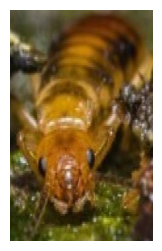


=============== TRANSFER MODEL PREDICTION ===============
===============================predict==============================================

Predicted Class from Test: Bees


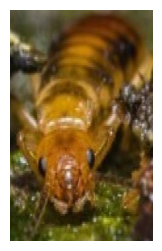


======================= SUMMARY =======================
Random Image Path: cropped_dataset/test\Earwigs\earwig-224-_jpg.rf.b5972c9ca07a6ed50a76b30bbda1bb79_0.jpg
RAW Model Prediction      : Snails
Transfer Learning Prediction : Bees


In [100]:
test_root = "cropped_dataset/test"

# Get ALL valid image paths recursively
all_images = glob(os.path.join(test_root, "*", "*.jpg")) \
             + glob(os.path.join(test_root, "*", "*.png")) \
             + glob(os.path.join(test_root, "*", "*.jpeg"))

if len(all_images) == 0:
    raise RuntimeError("No images found in cropped_dataset/test directory!")

random_img_path = random.choice(all_images)
print(f"\nRandomly Selected Test Image:\n{random_img_path}\n")


# ============================
# RESTORE CLASS NAMES + TRANSFORMS
# ============================

test_ds = datasets.ImageFolder(test_root)
classes = test_ds.classes

weights = ResNet50_Weights.IMAGENET1K_V2
test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=weights.transforms().mean, 
        std=weights.transforms().std
    )
])

test_loader = DataLoader(
    datasets.ImageFolder(test_root, transform=test_tf),
    batch_size=32,
    shuffle=False
)

# load raw resnet model - no transfer learning
raw_model = load_resnet50_model(
    weights_path="results_drive/raw_resnet/resnet50_raw_custom.pth",
    num_classes=len(classes),
    device=device,
    pretrained=False
)
print("Loaded RAW ResNet50 model (no transfer learning).")

# load transfer learning model
transfer_model = load_resnet50_model(
    weights_path="results_drive/transfer_resnet/resnet50_transfer_custom.pth",
    num_classes=len(classes),
    device=device,
    pretrained=False
)
print("Loaded TRANSFER LEARNING ResNet50 model.")

# RUN BOTH MODELS ON SAME IMAGE
print("\n================ RAW MODEL PREDICTION ================")
raw_pred = predict_single_image_demo(
    img_path=random_img_path,
    model=raw_model,
    test_tf=test_tf,
    classes=classes,
    device=device
)
print("\n=============== TRANSFER MODEL PREDICTION ===============")
transfer_pred = predict_single_image_demo(
    img_path=random_img_path,
    model=transfer_model,
    test_tf=test_tf,
    classes=classes,
    device=device
)

# PRINT SUMMARY
print("\n======================= SUMMARY =======================")
print(f"Random Image Path: {random_img_path}")
print(f"RAW Model Prediction      : {raw_pred}")
print(f"Transfer Learning Prediction : {transfer_pred}")
print("======================================================")